In [1]:
import torch
import torch.nn.functional as F
from torch_geometric.data import DataLoader, Batch
from torch.utils.data import DataLoader as TorchDataLoader, Subset
from itertools import combinations
import numpy as np
from sklearn.metrics import roc_auc_score, average_precision_score, accuracy_score
from utils2 import load_all_weights, FocalLoss, load_data
import os
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import matplotlib.pyplot as plt
from collections import defaultdict
import pickle
import torch.nn as nn
from torch_geometric.nn import GraphNorm, GCNConv, GATConv, global_add_pool as gap
from torch_geometric.data import Data, Batch
from torch_geometric.utils import add_self_loops
from rdkit import Chem
from rdkit.Chem import Draw
from PIL import Image
import io
import random
import pandas as pd  
import warnings
from matplotlib.colors import LinearSegmentedColormap
warnings.filterwarnings("ignore")

from torch_geometric.data import DataLoader as TorchDataLoader, Batch
from sklearn.metrics import roc_auc_score, average_precision_score, accuracy_score
from rdkit import Chem
from rdkit.Chem import Draw
import matplotlib.pyplot as plt
from torch_geometric.nn import MLP
import sys
torch.set_printoptions(threshold=sys.maxsize)

def set_seed(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)  
    torch.cuda.manual_seed(seed)  
    torch.cuda.manual_seed_all(seed)  
    
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
    np.random.seed(seed)
    random.seed(seed)
    
set_seed(2)

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)
    
rng = np.random.default_rng(8888)
rfloat = rng.random()


In [2]:
import torch_scatter

def scatter_(name, src, index, dim_size=None):
    r"""Aggregates all values from the :attr:`src` tensor at the indices
    specified in the :attr:`index` tensor along the first dimension.
    If multiple indices reference the same location, their contributions
    are aggregated according to :attr:`name` (either :obj:`"add"`,
    :obj:`"mean"` or :obj:`"max"`).

    Args:
        name (string): The aggregation to use (:obj:`"add"`, :obj:`"mean"`,
            :obj:`"max"`).
        src (Tensor): The source tensor.
        index (LongTensor): The indices of elements to scatter.
        dim_size (int, optional): Automatically create output tensor with size
            :attr:`dim_size` in the first dimension. If set to :attr:`None`, a
            minimal sized output tensor is returned. (default: :obj:`None`)

    :rtype: :class:`Tensor`
    """

    assert name in ['add', 'mean', 'max']

    op = getattr(torch_scatter, 'scatter_{}'.format(name))
    fill_value = -1e9 if name == 'max' else 0

    out = op(src, index, 0, None, dim_size)
    if isinstance(out, tuple):
        out = out[0]

    if name == 'max':
        out[out == fill_value] = 0

    return out

import torch
from torch_scatter import scatter_max, scatter_add

from torch_geometric.utils.num_nodes import maybe_num_nodes


def softmax(src, index, num_nodes=None):
    r"""Computes a sparsely evaluated softmax.
    Given a value tensor :attr:`src`, this function first groups the values
    along the first dimension based on the indices specified in :attr:`index`,
    and then proceeds to compute the softmax individually for each group.

    Args:
        src (Tensor): The source tensor.
        index (LongTensor): The indices of elements for applying the softmax.
        num_nodes (int, optional): The number of nodes, *i.e.*
            :obj:`max_val + 1` of :attr:`index`. (default: :obj:`None`)

    :rtype: :class:`Tensor`
    """

    num_nodes = maybe_num_nodes(index, num_nodes)

    out = src - scatter_max(src, index, dim=0, dim_size=num_nodes)[0][index]
    out = out.exp()
    out = out / (
        scatter_add(out, index, dim=0, dim_size=num_nodes)[index] + 1e-16)

    return out

from torch_geometric.nn.inits import reset

class GlobalAttention(torch.nn.Module):
    r"""Global soft attention layer from the `"Gated Graph Sequence Neural
    Networks" <https://arxiv.org/abs/1511.05493>`_ paper
    """
    def __init__(self, gate_nn, nn=None):
        super(GlobalAttention, self).__init__()
        self.gate_nn = gate_nn
        self.nn = nn

        self.reset_parameters()

    def reset_parameters(self):
        reset(self.gate_nn)
        reset(self.nn)


    def forward(self, x, batch, size=None):
        x = x.unsqueeze(-1) if x.dim() == 1 else x
        size = batch[-1].item() + 1 if size is None else size

        gate = self.gate_nn(x).view(-1, 1)
        x = self.nn(x) if self.nn is not None else x
        assert gate.dim() == x.dim() and gate.size(0) == x.size(0)
        gate = softmax(gate, batch, size)
        out = scatter_('add', gate * x, batch, size)

        return out, gate


    def __repr__(self):
        return '{}(gate_nn={}, nn={})'.format(self.__class__.__name__,
                                              self.gate_nn, self.nn)


======================= Fold 1/20 test start =======================

Fold 1 - Test Results:
  Task 0 (liv): Loss=nan, AUC=0.8472, PR AUC=0.7918, Accuracy=0.7647
  Task 1 (lun): Loss=nan, AUC=0.8714, PR AUC=0.9017, Accuracy=0.7647
  Task 2 (sto): Loss=nan, AUC=0.9714, PR AUC=0.9809, Accuracy=0.7647
  Task 3 (mgl): Loss=nan, AUC=0.9028, PR AUC=0.9237, Accuracy=0.8235

======================= Fold 2/20 test start =======================

Fold 2 - Test Results:
  Task 0 (liv): Loss=nan, AUC=0.6111, PR AUC=0.6676, Accuracy=0.6471
  Task 1 (lun): Loss=nan, AUC=0.5278, PR AUC=0.5468, Accuracy=0.6471
  Task 2 (sto): Loss=nan, AUC=0.7500, PR AUC=0.8465, Accuracy=0.5882
  Task 3 (mgl): Loss=nan, AUC=0.8194, PR AUC=0.7885, Accuracy=0.7059

======================= Fold 3/20 test start =======================

Fold 3 - Test Results:
  Task 0 (liv): Loss=nan, AUC=0.6667, PR AUC=0.6520, Accuracy=0.7059
  Task 1 (lun): Loss=nan, AUC=0.6944, PR AUC=0.7374, Accuracy=0.7647
  Task 2 (sto): Loss=nan, AU

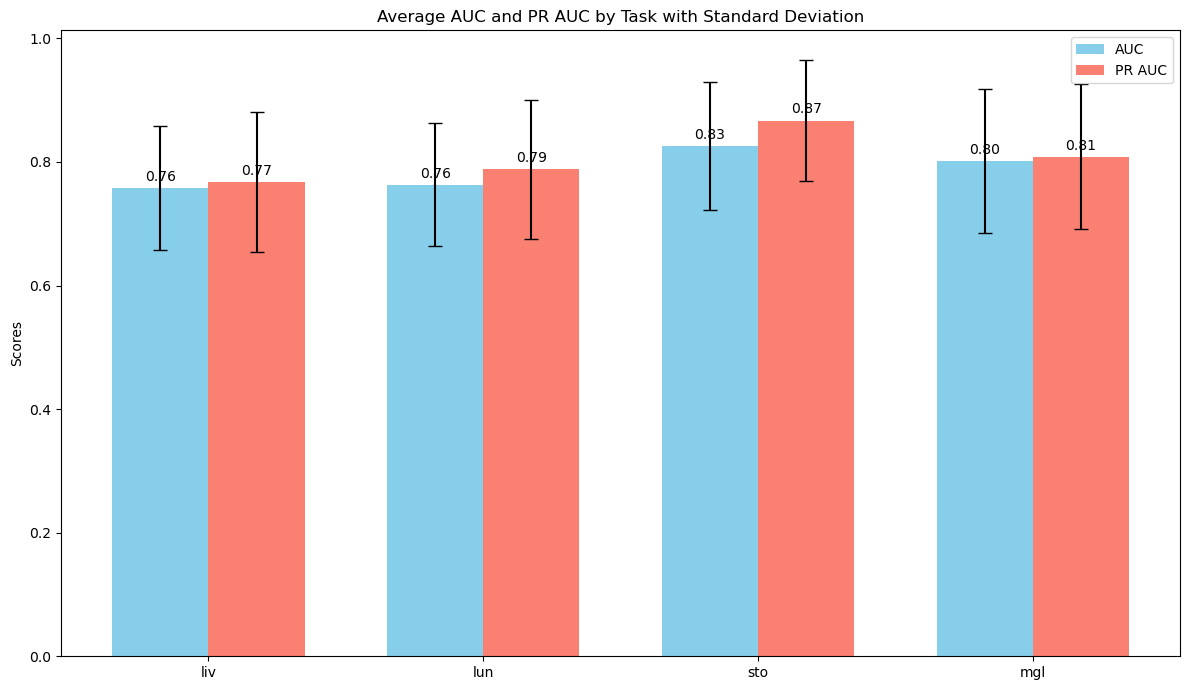

Saved predictions for task 'liv' to prediction_results/liv_predictions.csv
Saved predictions for task 'lun' to prediction_results/lun_predictions.csv
Saved predictions for task 'sto' to prediction_results/sto_predictions.csv
Saved predictions for task 'mgl' to prediction_results/mgl_predictions.csv

Folds with the highest average PR AUC: Fold 19 with PR AUC=0.9045

Folds with the lowest average PR AUC: Fold 12 with PR AUC=0.6199

Number of 0s and 1s for each task in Fold 19:
  Task 0 (liv): Number of zeros= 8, Number of 1s = 9
  Task 1 (lun): Number of zeros= 7, Number of 1s = 10
  Task 2 (sto): Number of zeros= 8, Number of 1s = 9
  Task 3 (mgl): Number of zeros= 9, Number of 1s = 8

Task liv - Visualise the attachment weights of Fold 19:
Top 1 SMILES: CCCCCCCCN(C)N=O, Prob: 0.5658
  Attention Scores: [0.1271764487028122, 0.1128411740064621, 0.08982916176319122, 0.08982916176319122, 0.08982916176319122, 0.08982916176319122, 0.08982916176319122, 0.05720971152186394, 0.05513972789049148

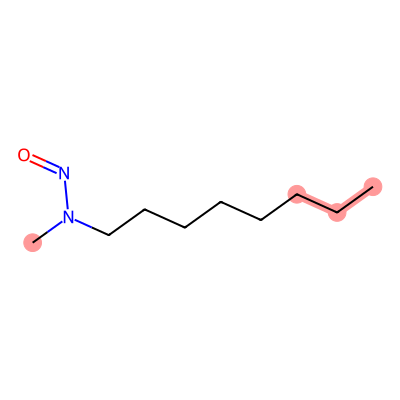

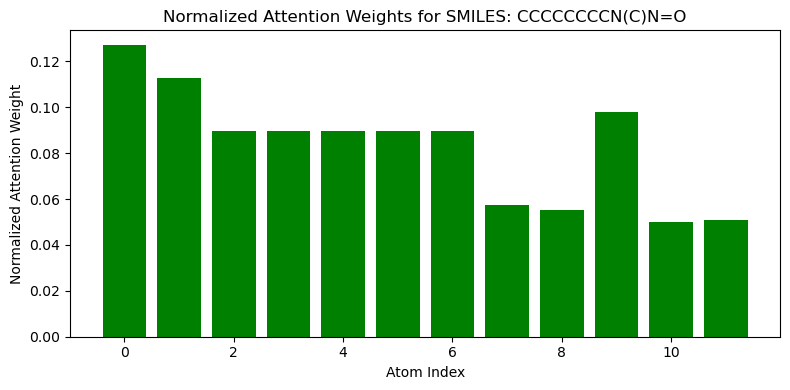

Top 2 SMILES: CCCCCCCN(C)N=O, Prob: 0.5653
  Attention Scores: [0.1374894082546234, 0.12184538692235947, 0.09976483881473541, 0.09976483881473541, 0.09976483881473541, 0.09976483881473541, 0.0630321279168129, 0.061126209795475006, 0.10699238628149033, 0.05466582998633385, 0.05578933656215668]
SMILES: CCCCCCCN(C)N=O
  Atom 0 (C): Attention Score = 0.1375
  Atom 1 (C): Attention Score = 0.1218
  Atom 2 (C): Attention Score = 0.0998
  Atom 3 (C): Attention Score = 0.0998
  Atom 4 (C): Attention Score = 0.0998
  Atom 5 (C): Attention Score = 0.0998
  Atom 6 (C): Attention Score = 0.0630
  Atom 7 (N): Attention Score = 0.0611
  Atom 8 (C): Attention Score = 0.1070
  Atom 9 (N): Attention Score = 0.0547
  Atom 10 (O): Attention Score = 0.0558


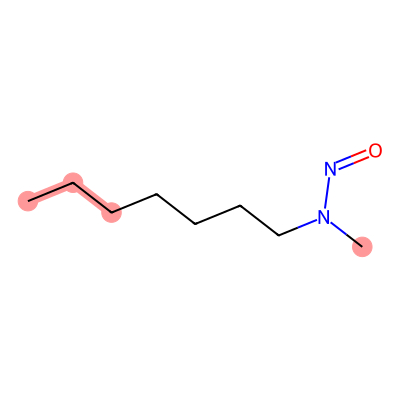

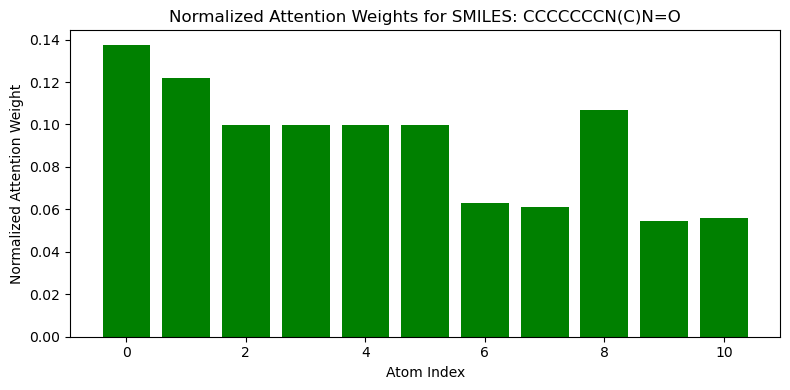

Top 3 SMILES: C1=CC2=C(C=C1Cl)OC3=C(O2)C=C(C=C3)Cl, Prob: 0.5329
  Attention Scores: [0.0928480327129364, 0.0928480327129364, 0.04711532965302467, 0.04711532965302467, 0.08583639562129974, 0.06442242860794067, 0.03431094065308571, 0.03550354391336441, 0.04711531847715378, 0.04711532220244408, 0.03550354391336441, 0.08583639562129974, 0.06442242860794067, 0.0928480327129364, 0.0928480327129364, 0.03431094065308571]
SMILES: C1=CC2=C(C=C1Cl)OC3=C(O2)C=C(C=C3)Cl
  Atom 0 (C): Attention Score = 0.0928
  Atom 1 (C): Attention Score = 0.0928
  Atom 2 (C): Attention Score = 0.0471
  Atom 3 (C): Attention Score = 0.0471
  Atom 4 (C): Attention Score = 0.0858
  Atom 5 (C): Attention Score = 0.0644
  Atom 6 (Cl): Attention Score = 0.0343
  Atom 7 (O): Attention Score = 0.0355
  Atom 8 (C): Attention Score = 0.0471
  Atom 9 (C): Attention Score = 0.0471
  Atom 10 (O): Attention Score = 0.0355
  Atom 11 (C): Attention Score = 0.0858
  Atom 12 (C): Attention Score = 0.0644
  Atom 13 (C): Attention S

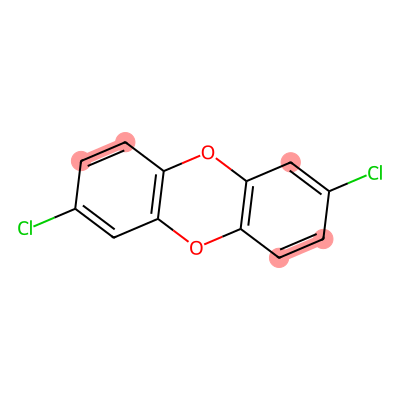

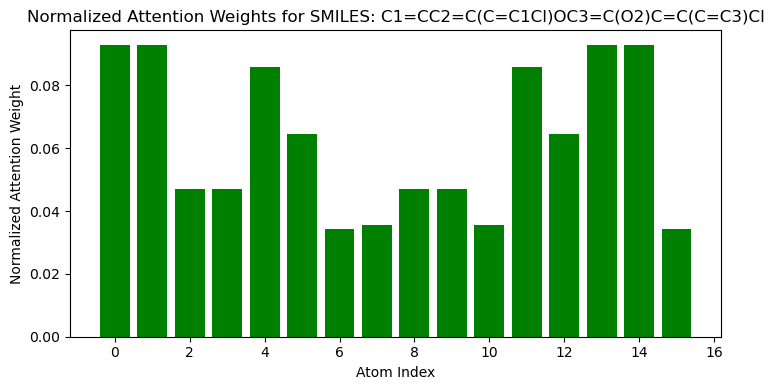

Top 4 SMILES: CC(Cl)Cl, Prob: 0.5144
  Attention Scores: [0.4116095006465912, 0.16768550872802734, 0.21035251021385193, 0.21035251021385193]
SMILES: CC(Cl)Cl
  Atom 0 (C): Attention Score = 0.4116
  Atom 1 (C): Attention Score = 0.1677
  Atom 2 (Cl): Attention Score = 0.2104
  Atom 3 (Cl): Attention Score = 0.2104


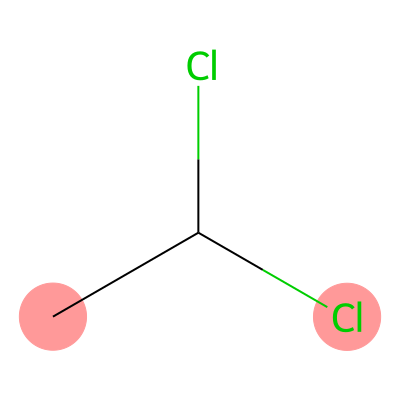

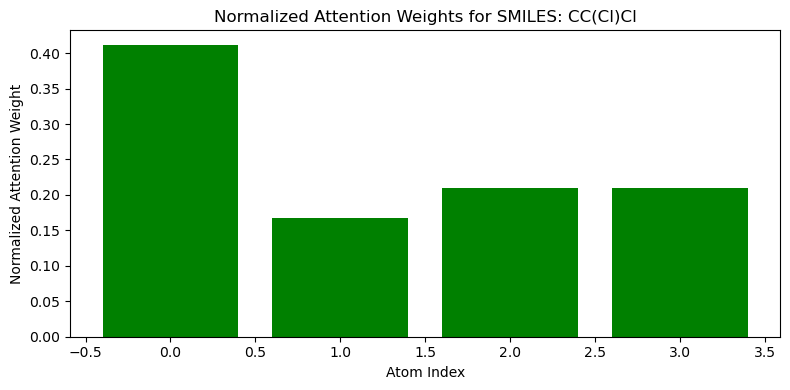

Top 5 SMILES: C1CC2=CC=C(C3=CC=CC1=C23)[N+](=O)[O-], Prob: 0.5015
  Attention Scores: [0.03979728743433952, 0.03979728743433952, 0.051078762859106064, 0.10349266231060028, 0.10349266231060028, 0.05739755928516388, 0.07595669478178024, 0.10349266231060028, 0.10381656885147095, 0.10349266231060028, 0.051078762859106064, 0.05150921270251274, 0.03886783495545387, 0.03846428170800209, 0.038265079259872437]
SMILES: C1CC2=CC=C(C3=CC=CC1=C23)[N+](=O)[O-]
  Atom 0 (C): Attention Score = 0.0398
  Atom 1 (C): Attention Score = 0.0398
  Atom 2 (C): Attention Score = 0.0511
  Atom 3 (C): Attention Score = 0.1035
  Atom 4 (C): Attention Score = 0.1035
  Atom 5 (C): Attention Score = 0.0574
  Atom 6 (C): Attention Score = 0.0760
  Atom 7 (C): Attention Score = 0.1035
  Atom 8 (C): Attention Score = 0.1038
  Atom 9 (C): Attention Score = 0.1035
  Atom 10 (C): Attention Score = 0.0511
  Atom 11 (C): Attention Score = 0.0515
  Atom 12 (N): Attention Score = 0.0389
  Atom 13 (O): Attention Score = 0.0385

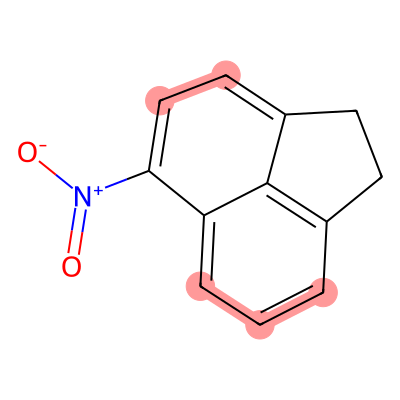

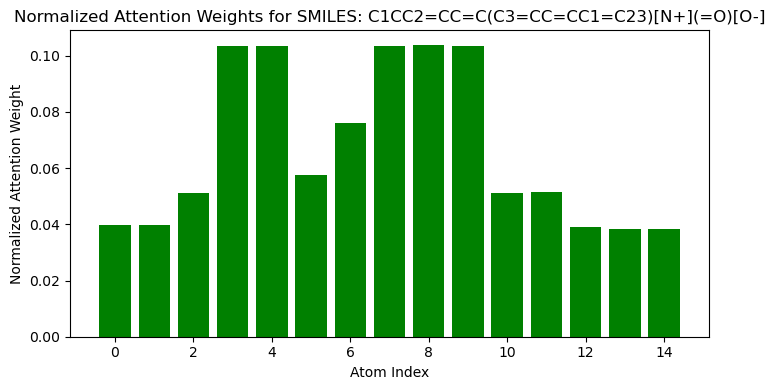

Top 6 SMILES: C1=CC=C2C(=C1)C3=CC=CC4=C3C5=C2C6=C(C=C5C=C4)[C@H]([C@@H]([C@H]7[C@@H]6O7)O)O, Prob: 0.4871
  Attention Scores: [0.05747136101126671, 0.05747136101126671, 0.05686409771442413, 0.02658361755311489, 0.02658361755311489, 0.05686409771442413, 0.02658361755311489, 0.05686409771442413, 0.05747136101126671, 0.05686409771442413, 0.052414823323488235, 0.02225816249847412, 0.02225816249847412, 0.02225816249847412, 0.022749701514840126, 0.02696337178349495, 0.03274638205766678, 0.05241481959819794, 0.05686409771442413, 0.05686409771442413, 0.022048650309443474, 0.021495074033737183, 0.02155306376516819, 0.02206757664680481, 0.02164444699883461, 0.021508364006876945, 0.022269774228334427]
SMILES: C1=CC=C2C(=C1)C3=CC=CC4=C3C5=C2C6=C(C=C5C=C4)[C@H]([C@@H]([C@H]7[C@@H]6O7)O)O
  Atom 0 (C): Attention Score = 0.0575
  Atom 1 (C): Attention Score = 0.0575
  Atom 2 (C): Attention Score = 0.0569
  Atom 3 (C): Attention Score = 0.0266
  Atom 4 (C): Attention Score = 0.0266
  Atom 5 (C): Atten

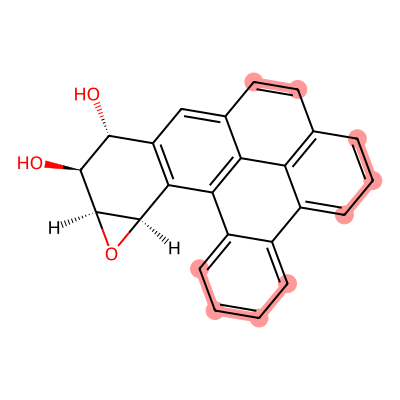

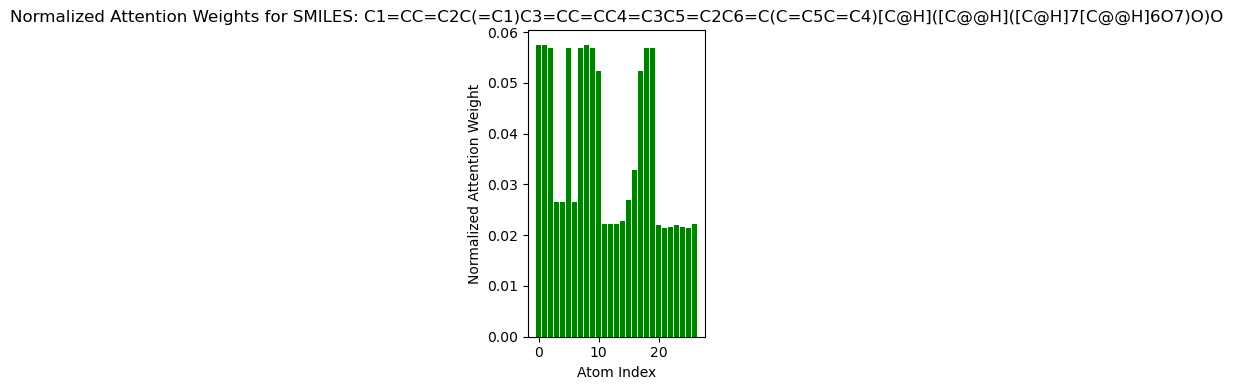

Top 7 SMILES: CCCCOC(=O)C1=CC=CC=C1C(=O)OCC2=CC=CC=C2, Prob: 0.4832
  Attention Scores: [0.025151792913675308, 0.025120440870523453, 0.02496323548257351, 0.025464093312621117, 0.025471579283475876, 0.025063183158636093, 0.024742545560002327, 0.03407354652881622, 0.06586509197950363, 0.0662960335612297, 0.0662960335612297, 0.06586509197950363, 0.03407355025410652, 0.025063183158636093, 0.024742545560002327, 0.025471579283475876, 0.027080297470092773, 0.05857786908745766, 0.06586509197950363, 0.0662960335612297, 0.0662960335612297, 0.0662960335612297, 0.06586509197950363]
SMILES: CCCCOC(=O)C1=CC=CC=C1C(=O)OCC2=CC=CC=C2
  Atom 0 (C): Attention Score = 0.0252
  Atom 1 (C): Attention Score = 0.0251
  Atom 2 (C): Attention Score = 0.0250
  Atom 3 (C): Attention Score = 0.0255
  Atom 4 (O): Attention Score = 0.0255
  Atom 5 (C): Attention Score = 0.0251
  Atom 6 (O): Attention Score = 0.0247
  Atom 7 (C): Attention Score = 0.0341
  Atom 8 (C): Attention Score = 0.0659
  Atom 9 (C): Attention 

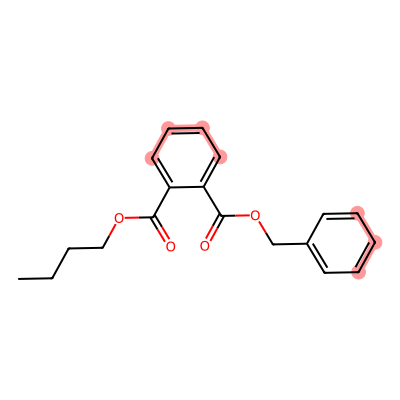

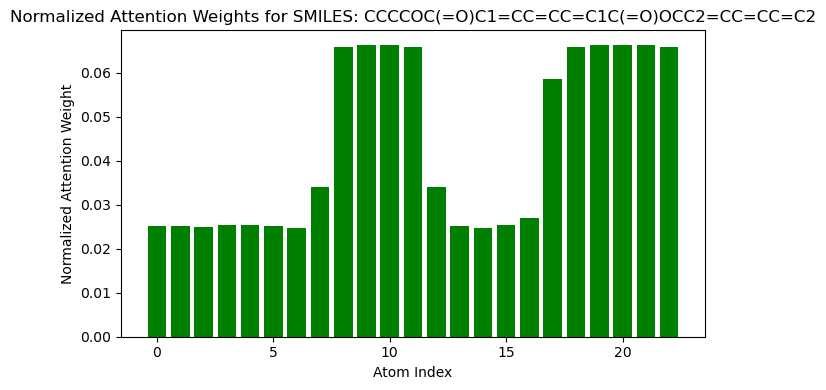


Task lun - Visualise the attachment weights of Fold 19:
Top 1 SMILES: CCCCCCCCN(C)N=O, Prob: 0.6500
  Attention Scores: [0.1271764487028122, 0.1128411740064621, 0.08982916176319122, 0.08982916176319122, 0.08982916176319122, 0.08982916176319122, 0.08982916176319122, 0.05720971152186394, 0.055139727890491486, 0.09788727760314941, 0.049914926290512085, 0.05068492144346237]
SMILES: CCCCCCCCN(C)N=O
  Atom 0 (C): Attention Score = 0.1272
  Atom 1 (C): Attention Score = 0.1128
  Atom 2 (C): Attention Score = 0.0898
  Atom 3 (C): Attention Score = 0.0898
  Atom 4 (C): Attention Score = 0.0898
  Atom 5 (C): Attention Score = 0.0898
  Atom 6 (C): Attention Score = 0.0898
  Atom 7 (C): Attention Score = 0.0572
  Atom 8 (N): Attention Score = 0.0551
  Atom 9 (C): Attention Score = 0.0979
  Atom 10 (N): Attention Score = 0.0499
  Atom 11 (O): Attention Score = 0.0507


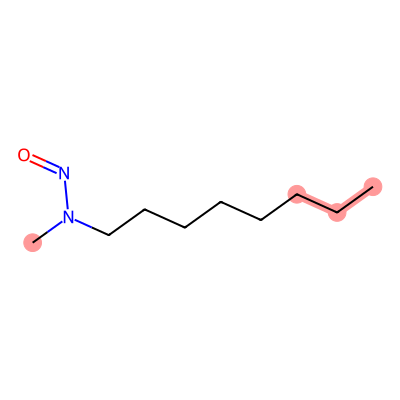

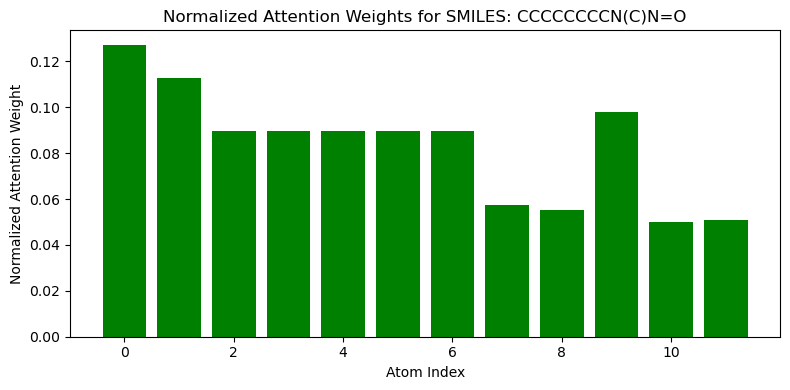

Top 2 SMILES: CCCCCCCN(C)N=O, Prob: 0.6481
  Attention Scores: [0.1374894082546234, 0.12184538692235947, 0.09976483881473541, 0.09976483881473541, 0.09976483881473541, 0.09976483881473541, 0.0630321279168129, 0.061126209795475006, 0.10699238628149033, 0.05466582998633385, 0.05578933656215668]
SMILES: CCCCCCCN(C)N=O
  Atom 0 (C): Attention Score = 0.1375
  Atom 1 (C): Attention Score = 0.1218
  Atom 2 (C): Attention Score = 0.0998
  Atom 3 (C): Attention Score = 0.0998
  Atom 4 (C): Attention Score = 0.0998
  Atom 5 (C): Attention Score = 0.0998
  Atom 6 (C): Attention Score = 0.0630
  Atom 7 (N): Attention Score = 0.0611
  Atom 8 (C): Attention Score = 0.1070
  Atom 9 (N): Attention Score = 0.0547
  Atom 10 (O): Attention Score = 0.0558


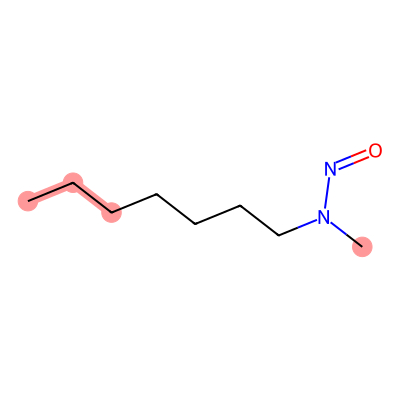

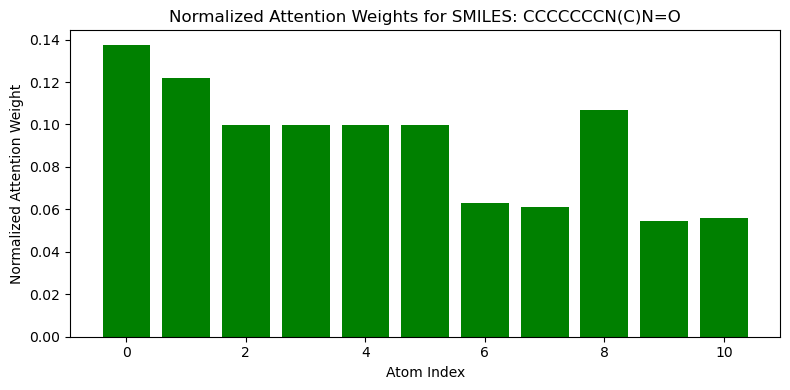

Top 3 SMILES: C1=CC2=C(C=C1Cl)OC3=C(O2)C=C(C=C3)Cl, Prob: 0.5822
  Attention Scores: [0.0928480327129364, 0.0928480327129364, 0.04711532965302467, 0.04711532965302467, 0.08583639562129974, 0.06442242860794067, 0.03431094065308571, 0.03550354391336441, 0.04711531847715378, 0.04711532220244408, 0.03550354391336441, 0.08583639562129974, 0.06442242860794067, 0.0928480327129364, 0.0928480327129364, 0.03431094065308571]
SMILES: C1=CC2=C(C=C1Cl)OC3=C(O2)C=C(C=C3)Cl
  Atom 0 (C): Attention Score = 0.0928
  Atom 1 (C): Attention Score = 0.0928
  Atom 2 (C): Attention Score = 0.0471
  Atom 3 (C): Attention Score = 0.0471
  Atom 4 (C): Attention Score = 0.0858
  Atom 5 (C): Attention Score = 0.0644
  Atom 6 (Cl): Attention Score = 0.0343
  Atom 7 (O): Attention Score = 0.0355
  Atom 8 (C): Attention Score = 0.0471
  Atom 9 (C): Attention Score = 0.0471
  Atom 10 (O): Attention Score = 0.0355
  Atom 11 (C): Attention Score = 0.0858
  Atom 12 (C): Attention Score = 0.0644
  Atom 13 (C): Attention S

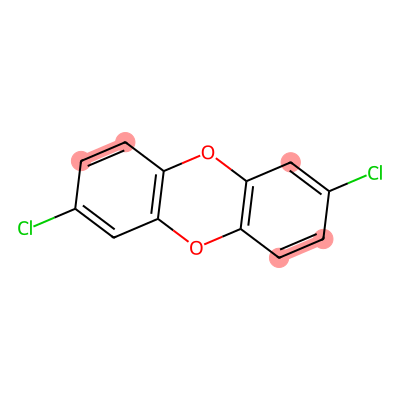

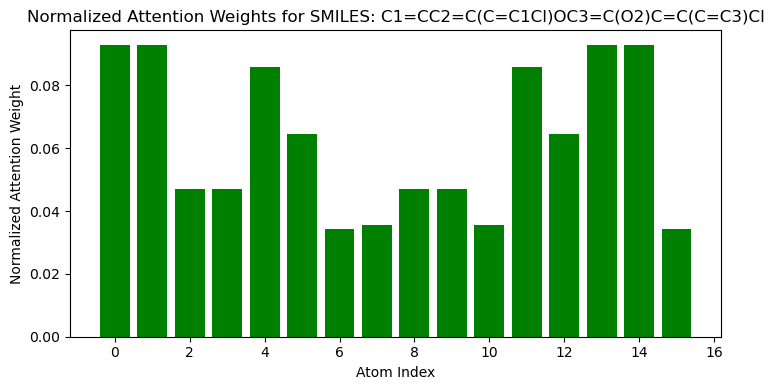

Top 4 SMILES: C1=C(OC(=C1)[N+](=O)[O-])C2=NN=C(O2)N, Prob: 0.5481
  Attention Scores: [0.12161625921726227, 0.11587470769882202, 0.0664968341588974, 0.105595663189888, 0.12161625921726227, 0.04609908536076546, 0.045326828956604004, 0.04486200585961342, 0.06355616450309753, 0.052458833903074265, 0.052458833903074265, 0.05181385576725006, 0.0664968341588974, 0.04572784900665283]
SMILES: C1=C(OC(=C1)[N+](=O)[O-])C2=NN=C(O2)N
  Atom 0 (C): Attention Score = 0.1216
  Atom 1 (C): Attention Score = 0.1159
  Atom 2 (O): Attention Score = 0.0665
  Atom 3 (C): Attention Score = 0.1056
  Atom 4 (C): Attention Score = 0.1216
  Atom 5 (N): Attention Score = 0.0461
  Atom 6 (O): Attention Score = 0.0453
  Atom 7 (O): Attention Score = 0.0449
  Atom 8 (C): Attention Score = 0.0636
  Atom 9 (N): Attention Score = 0.0525
  Atom 10 (N): Attention Score = 0.0525
  Atom 11 (C): Attention Score = 0.0518
  Atom 12 (O): Attention Score = 0.0665
  Atom 13 (N): Attention Score = 0.0457


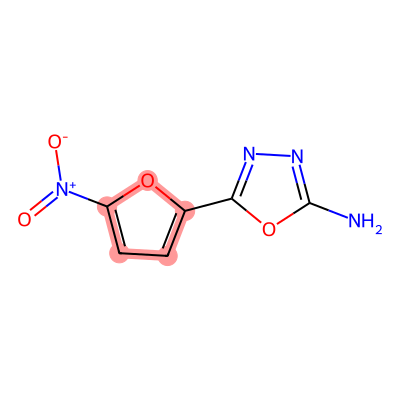

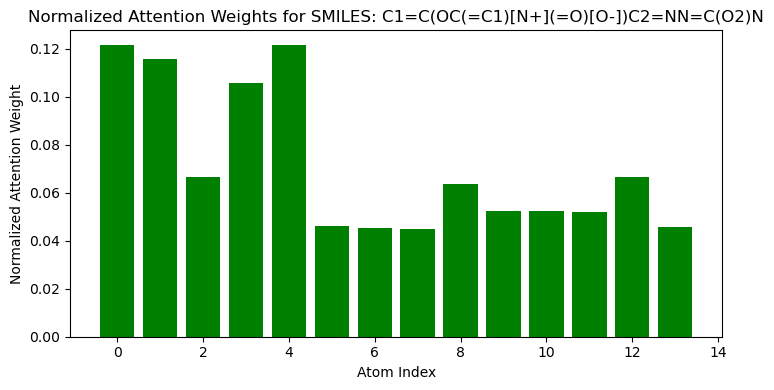

Top 5 SMILES: CC(Cl)Cl, Prob: 0.5069
  Attention Scores: [0.4116095006465912, 0.16768550872802734, 0.21035251021385193, 0.21035251021385193]
SMILES: CC(Cl)Cl
  Atom 0 (C): Attention Score = 0.4116
  Atom 1 (C): Attention Score = 0.1677
  Atom 2 (Cl): Attention Score = 0.2104
  Atom 3 (Cl): Attention Score = 0.2104


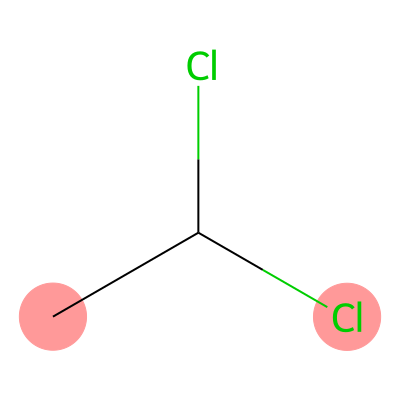

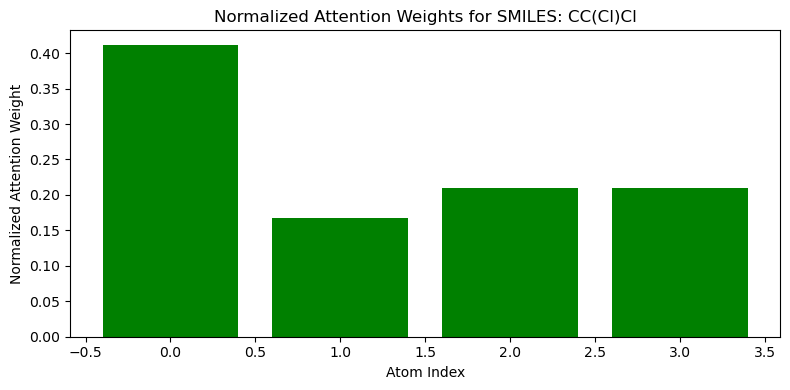

Top 6 SMILES: C1CC2=CC=C(C3=CC=CC1=C23)[N+](=O)[O-], Prob: 0.4960
  Attention Scores: [0.03979728743433952, 0.03979728743433952, 0.051078762859106064, 0.10349266231060028, 0.10349266231060028, 0.05739755928516388, 0.07595669478178024, 0.10349266231060028, 0.10381656885147095, 0.10349266231060028, 0.051078762859106064, 0.05150921270251274, 0.03886783495545387, 0.03846428170800209, 0.038265079259872437]
SMILES: C1CC2=CC=C(C3=CC=CC1=C23)[N+](=O)[O-]
  Atom 0 (C): Attention Score = 0.0398
  Atom 1 (C): Attention Score = 0.0398
  Atom 2 (C): Attention Score = 0.0511
  Atom 3 (C): Attention Score = 0.1035
  Atom 4 (C): Attention Score = 0.1035
  Atom 5 (C): Attention Score = 0.0574
  Atom 6 (C): Attention Score = 0.0760
  Atom 7 (C): Attention Score = 0.1035
  Atom 8 (C): Attention Score = 0.1038
  Atom 9 (C): Attention Score = 0.1035
  Atom 10 (C): Attention Score = 0.0511
  Atom 11 (C): Attention Score = 0.0515
  Atom 12 (N): Attention Score = 0.0389
  Atom 13 (O): Attention Score = 0.0385

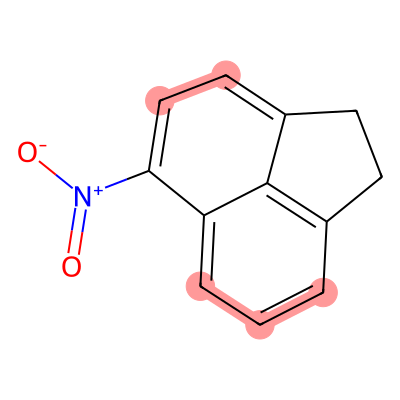

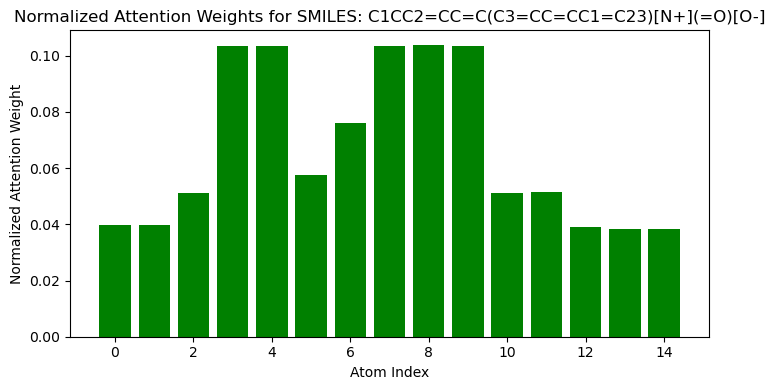

Top 7 SMILES: C1=CC=C2C(=C1)C3=CC=CC4=C3C5=C2C6=C(C=C5C=C4)[C@H]([C@@H]([C@H]7[C@@H]6O7)O)O, Prob: 0.4763
  Attention Scores: [0.05747136101126671, 0.05747136101126671, 0.05686409771442413, 0.02658361755311489, 0.02658361755311489, 0.05686409771442413, 0.02658361755311489, 0.05686409771442413, 0.05747136101126671, 0.05686409771442413, 0.052414823323488235, 0.02225816249847412, 0.02225816249847412, 0.02225816249847412, 0.022749701514840126, 0.02696337178349495, 0.03274638205766678, 0.05241481959819794, 0.05686409771442413, 0.05686409771442413, 0.022048650309443474, 0.021495074033737183, 0.02155306376516819, 0.02206757664680481, 0.02164444699883461, 0.021508364006876945, 0.022269774228334427]
SMILES: C1=CC=C2C(=C1)C3=CC=CC4=C3C5=C2C6=C(C=C5C=C4)[C@H]([C@@H]([C@H]7[C@@H]6O7)O)O
  Atom 0 (C): Attention Score = 0.0575
  Atom 1 (C): Attention Score = 0.0575
  Atom 2 (C): Attention Score = 0.0569
  Atom 3 (C): Attention Score = 0.0266
  Atom 4 (C): Attention Score = 0.0266
  Atom 5 (C): Atten

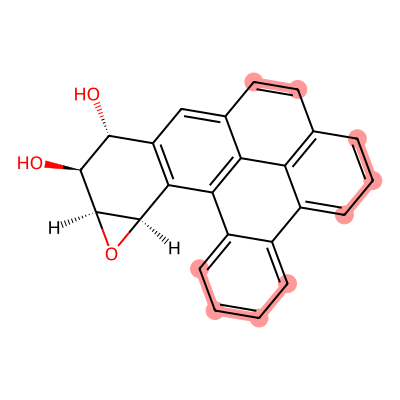

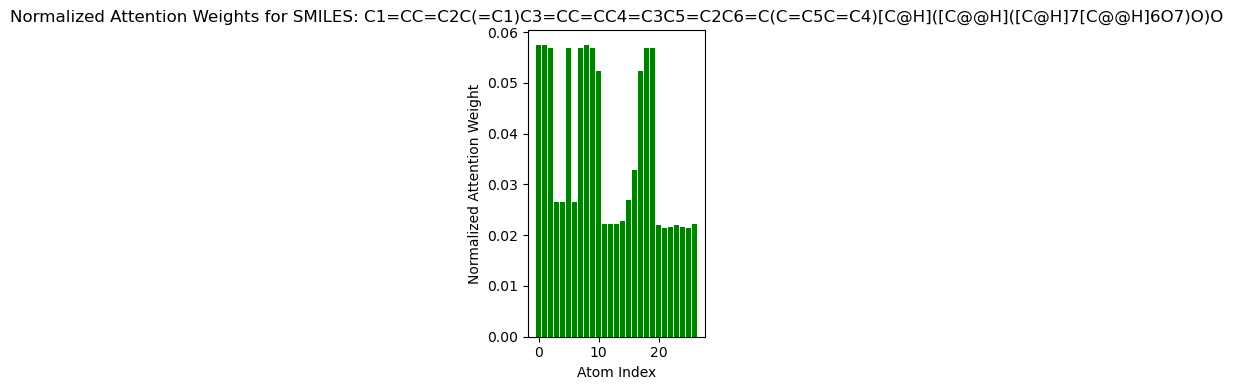

Top 8 SMILES: CCCCOC(=O)C1=CC=CC=C1C(=O)OCC2=CC=CC=C2, Prob: 0.4610
  Attention Scores: [0.025151792913675308, 0.025120440870523453, 0.02496323548257351, 0.025464093312621117, 0.025471579283475876, 0.025063183158636093, 0.024742545560002327, 0.03407354652881622, 0.06586509197950363, 0.0662960335612297, 0.0662960335612297, 0.06586509197950363, 0.03407355025410652, 0.025063183158636093, 0.024742545560002327, 0.025471579283475876, 0.027080297470092773, 0.05857786908745766, 0.06586509197950363, 0.0662960335612297, 0.0662960335612297, 0.0662960335612297, 0.06586509197950363]
SMILES: CCCCOC(=O)C1=CC=CC=C1C(=O)OCC2=CC=CC=C2
  Atom 0 (C): Attention Score = 0.0252
  Atom 1 (C): Attention Score = 0.0251
  Atom 2 (C): Attention Score = 0.0250
  Atom 3 (C): Attention Score = 0.0255
  Atom 4 (O): Attention Score = 0.0255
  Atom 5 (C): Attention Score = 0.0251
  Atom 6 (O): Attention Score = 0.0247
  Atom 7 (C): Attention Score = 0.0341
  Atom 8 (C): Attention Score = 0.0659
  Atom 9 (C): Attention 

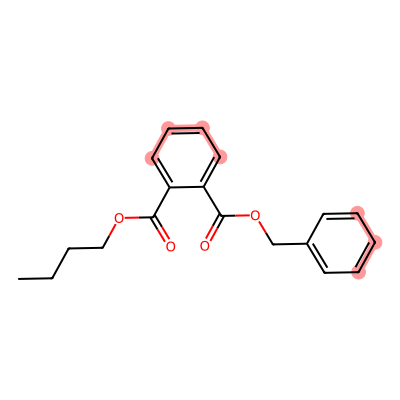

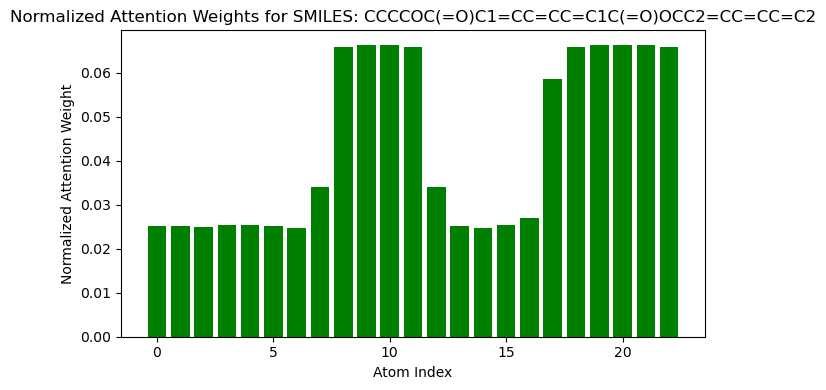

Top 9 SMILES: CCNC1=NC(=NC(=N1)Cl)NC(C)C, Prob: 0.4569
  Attention Scores: [0.044076379388570786, 0.044237054884433746, 0.046395763754844666, 0.07406890392303467, 0.07842713594436646, 0.07406889647245407, 0.07842713594436646, 0.04421917721629143, 0.07842713594436646, 0.04134904220700264, 0.10541525483131409, 0.08060331642627716, 0.10514244437217712, 0.10514244437217712]
SMILES: CCNC1=NC(=NC(=N1)Cl)NC(C)C
  Atom 0 (C): Attention Score = 0.0441
  Atom 1 (C): Attention Score = 0.0442
  Atom 2 (N): Attention Score = 0.0464
  Atom 3 (C): Attention Score = 0.0741
  Atom 4 (N): Attention Score = 0.0784
  Atom 5 (C): Attention Score = 0.0741
  Atom 6 (N): Attention Score = 0.0784
  Atom 7 (C): Attention Score = 0.0442
  Atom 8 (N): Attention Score = 0.0784
  Atom 9 (Cl): Attention Score = 0.0413
  Atom 10 (N): Attention Score = 0.1054
  Atom 11 (C): Attention Score = 0.0806
  Atom 12 (C): Attention Score = 0.1051
  Atom 13 (C): Attention Score = 0.1051


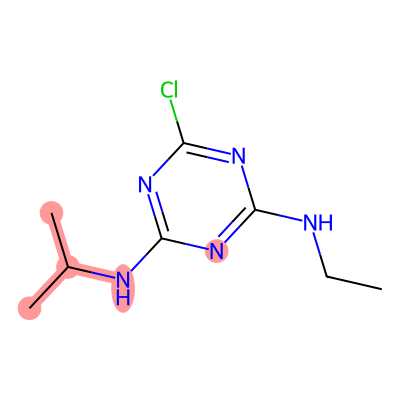

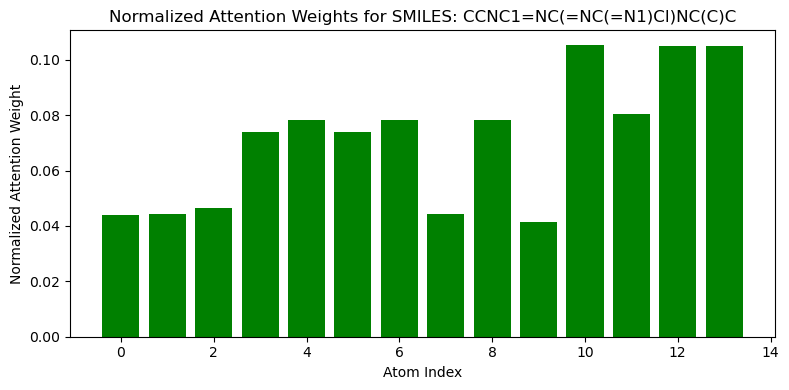


Task sto - Visualise the attachment weights of Fold 19:
Top 1 SMILES: CCCCCCCN(C)N=O, Prob: 0.7170
  Attention Scores: [0.1374894082546234, 0.12184538692235947, 0.09976483881473541, 0.09976483881473541, 0.09976483881473541, 0.09976483881473541, 0.0630321279168129, 0.061126209795475006, 0.10699238628149033, 0.05466582998633385, 0.05578933656215668]
SMILES: CCCCCCCN(C)N=O
  Atom 0 (C): Attention Score = 0.1375
  Atom 1 (C): Attention Score = 0.1218
  Atom 2 (C): Attention Score = 0.0998
  Atom 3 (C): Attention Score = 0.0998
  Atom 4 (C): Attention Score = 0.0998
  Atom 5 (C): Attention Score = 0.0998
  Atom 6 (C): Attention Score = 0.0630
  Atom 7 (N): Attention Score = 0.0611
  Atom 8 (C): Attention Score = 0.1070
  Atom 9 (N): Attention Score = 0.0547
  Atom 10 (O): Attention Score = 0.0558


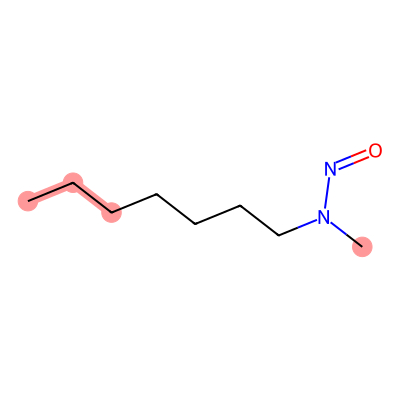

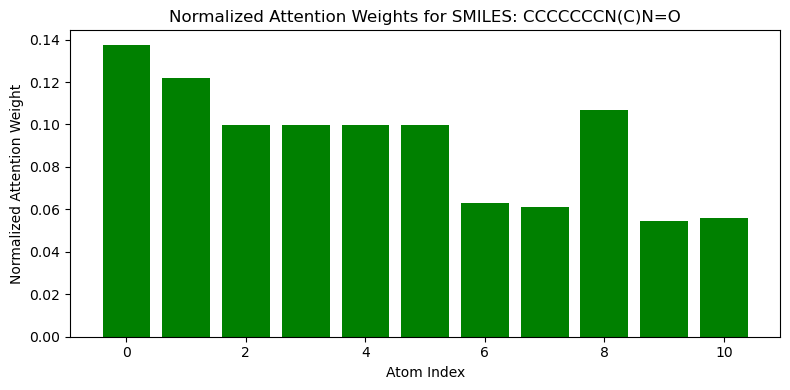

Top 2 SMILES: CCCCCCCCN(C)N=O, Prob: 0.7143
  Attention Scores: [0.1271764487028122, 0.1128411740064621, 0.08982916176319122, 0.08982916176319122, 0.08982916176319122, 0.08982916176319122, 0.08982916176319122, 0.05720971152186394, 0.055139727890491486, 0.09788727760314941, 0.049914926290512085, 0.05068492144346237]
SMILES: CCCCCCCCN(C)N=O
  Atom 0 (C): Attention Score = 0.1272
  Atom 1 (C): Attention Score = 0.1128
  Atom 2 (C): Attention Score = 0.0898
  Atom 3 (C): Attention Score = 0.0898
  Atom 4 (C): Attention Score = 0.0898
  Atom 5 (C): Attention Score = 0.0898
  Atom 6 (C): Attention Score = 0.0898
  Atom 7 (C): Attention Score = 0.0572
  Atom 8 (N): Attention Score = 0.0551
  Atom 9 (C): Attention Score = 0.0979
  Atom 10 (N): Attention Score = 0.0499
  Atom 11 (O): Attention Score = 0.0507


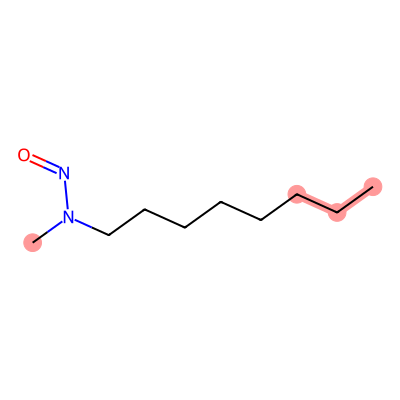

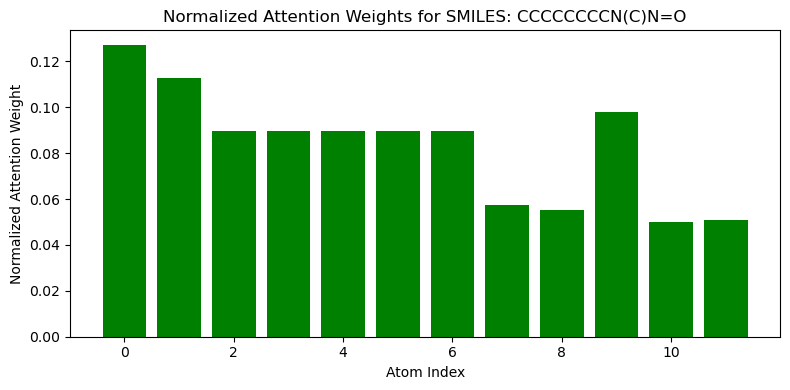

Top 3 SMILES: CC(Cl)Cl, Prob: 0.6616
  Attention Scores: [0.4116095006465912, 0.16768550872802734, 0.21035251021385193, 0.21035251021385193]
SMILES: CC(Cl)Cl
  Atom 0 (C): Attention Score = 0.4116
  Atom 1 (C): Attention Score = 0.1677
  Atom 2 (Cl): Attention Score = 0.2104
  Atom 3 (Cl): Attention Score = 0.2104


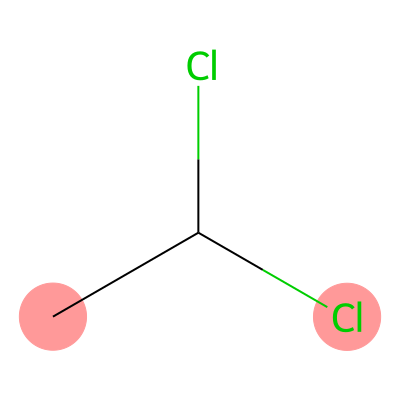

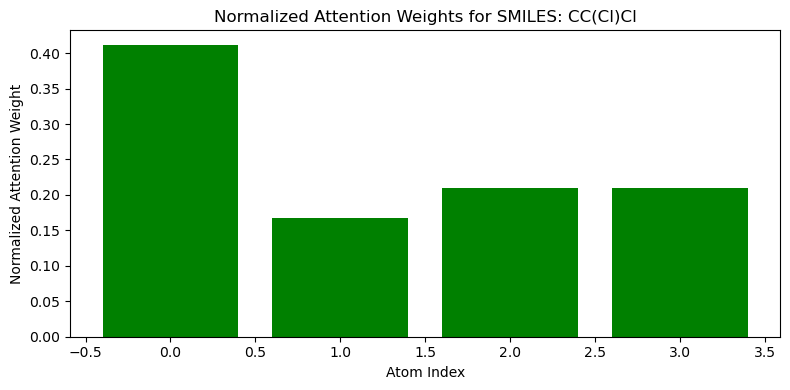

Top 4 SMILES: C1=CC2=C(C=C1Cl)OC3=C(O2)C=C(C=C3)Cl, Prob: 0.5566
  Attention Scores: [0.0928480327129364, 0.0928480327129364, 0.04711532965302467, 0.04711532965302467, 0.08583639562129974, 0.06442242860794067, 0.03431094065308571, 0.03550354391336441, 0.04711531847715378, 0.04711532220244408, 0.03550354391336441, 0.08583639562129974, 0.06442242860794067, 0.0928480327129364, 0.0928480327129364, 0.03431094065308571]
SMILES: C1=CC2=C(C=C1Cl)OC3=C(O2)C=C(C=C3)Cl
  Atom 0 (C): Attention Score = 0.0928
  Atom 1 (C): Attention Score = 0.0928
  Atom 2 (C): Attention Score = 0.0471
  Atom 3 (C): Attention Score = 0.0471
  Atom 4 (C): Attention Score = 0.0858
  Atom 5 (C): Attention Score = 0.0644
  Atom 6 (Cl): Attention Score = 0.0343
  Atom 7 (O): Attention Score = 0.0355
  Atom 8 (C): Attention Score = 0.0471
  Atom 9 (C): Attention Score = 0.0471
  Atom 10 (O): Attention Score = 0.0355
  Atom 11 (C): Attention Score = 0.0858
  Atom 12 (C): Attention Score = 0.0644
  Atom 13 (C): Attention S

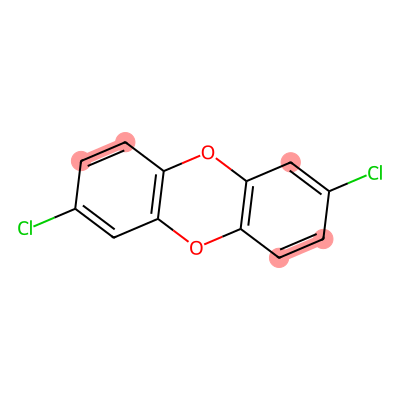

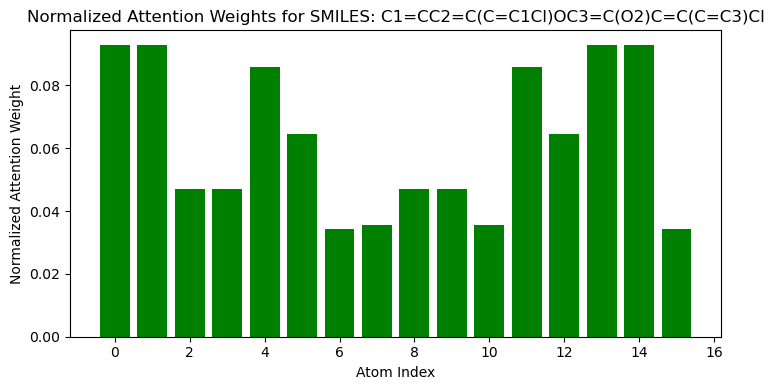

Top 5 SMILES: C1=C(OC(=C1)[N+](=O)[O-])C2=NN=C(O2)N, Prob: 0.5086
  Attention Scores: [0.12161625921726227, 0.11587470769882202, 0.0664968341588974, 0.105595663189888, 0.12161625921726227, 0.04609908536076546, 0.045326828956604004, 0.04486200585961342, 0.06355616450309753, 0.052458833903074265, 0.052458833903074265, 0.05181385576725006, 0.0664968341588974, 0.04572784900665283]
SMILES: C1=C(OC(=C1)[N+](=O)[O-])C2=NN=C(O2)N
  Atom 0 (C): Attention Score = 0.1216
  Atom 1 (C): Attention Score = 0.1159
  Atom 2 (O): Attention Score = 0.0665
  Atom 3 (C): Attention Score = 0.1056
  Atom 4 (C): Attention Score = 0.1216
  Atom 5 (N): Attention Score = 0.0461
  Atom 6 (O): Attention Score = 0.0453
  Atom 7 (O): Attention Score = 0.0449
  Atom 8 (C): Attention Score = 0.0636
  Atom 9 (N): Attention Score = 0.0525
  Atom 10 (N): Attention Score = 0.0525
  Atom 11 (C): Attention Score = 0.0518
  Atom 12 (O): Attention Score = 0.0665
  Atom 13 (N): Attention Score = 0.0457


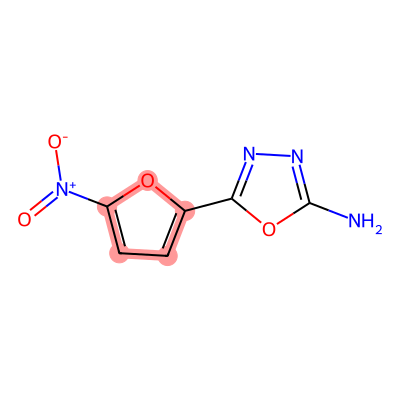

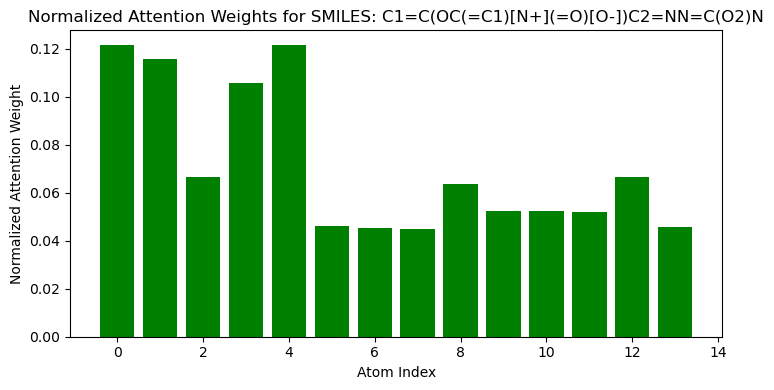

Top 6 SMILES: C1C(O1)CCl, Prob: 0.5024
  Attention Scores: [0.2622259557247162, 0.22121648490428925, 0.26173514127731323, 0.14420528709888458, 0.11061703413724899]
SMILES: C1C(O1)CCl
  Atom 0 (C): Attention Score = 0.2622
  Atom 1 (C): Attention Score = 0.2212
  Atom 2 (O): Attention Score = 0.2617
  Atom 3 (C): Attention Score = 0.1442
  Atom 4 (Cl): Attention Score = 0.1106


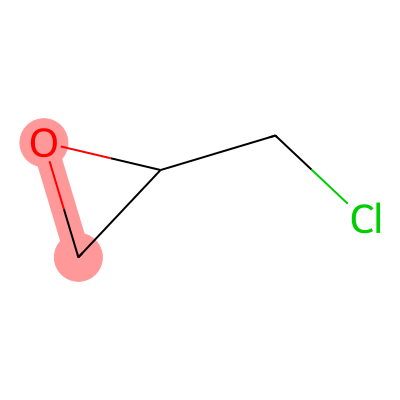

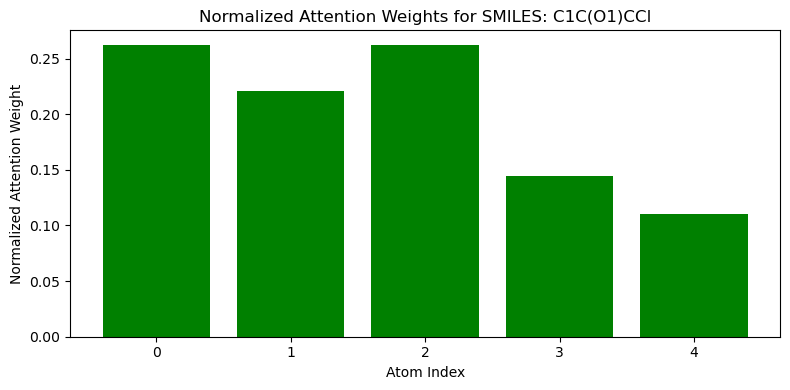

Top 7 SMILES: CCCCOC(=O)C1=CC=CC=C1C(=O)OCC2=CC=CC=C2, Prob: 0.4823
  Attention Scores: [0.025151792913675308, 0.025120440870523453, 0.02496323548257351, 0.025464093312621117, 0.025471579283475876, 0.025063183158636093, 0.024742545560002327, 0.03407354652881622, 0.06586509197950363, 0.0662960335612297, 0.0662960335612297, 0.06586509197950363, 0.03407355025410652, 0.025063183158636093, 0.024742545560002327, 0.025471579283475876, 0.027080297470092773, 0.05857786908745766, 0.06586509197950363, 0.0662960335612297, 0.0662960335612297, 0.0662960335612297, 0.06586509197950363]
SMILES: CCCCOC(=O)C1=CC=CC=C1C(=O)OCC2=CC=CC=C2
  Atom 0 (C): Attention Score = 0.0252
  Atom 1 (C): Attention Score = 0.0251
  Atom 2 (C): Attention Score = 0.0250
  Atom 3 (C): Attention Score = 0.0255
  Atom 4 (O): Attention Score = 0.0255
  Atom 5 (C): Attention Score = 0.0251
  Atom 6 (O): Attention Score = 0.0247
  Atom 7 (C): Attention Score = 0.0341
  Atom 8 (C): Attention Score = 0.0659
  Atom 9 (C): Attention 

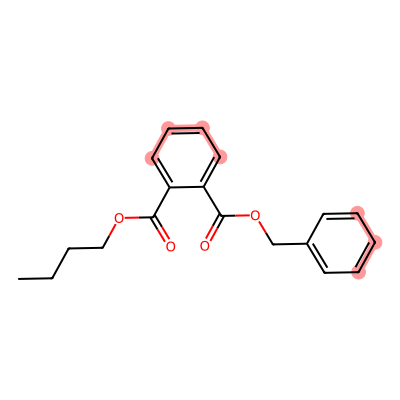

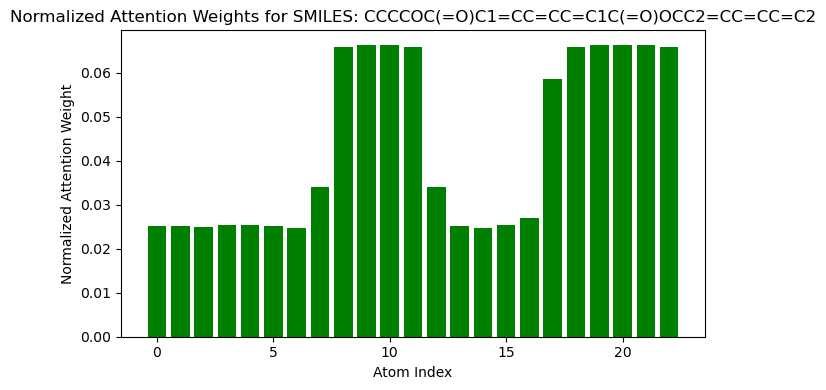

Top 8 SMILES: CCNC1=NC(=NC(=N1)Cl)NC(C)C, Prob: 0.4816
  Attention Scores: [0.044076379388570786, 0.044237054884433746, 0.046395763754844666, 0.07406890392303467, 0.07842713594436646, 0.07406889647245407, 0.07842713594436646, 0.04421917721629143, 0.07842713594436646, 0.04134904220700264, 0.10541525483131409, 0.08060331642627716, 0.10514244437217712, 0.10514244437217712]
SMILES: CCNC1=NC(=NC(=N1)Cl)NC(C)C
  Atom 0 (C): Attention Score = 0.0441
  Atom 1 (C): Attention Score = 0.0442
  Atom 2 (N): Attention Score = 0.0464
  Atom 3 (C): Attention Score = 0.0741
  Atom 4 (N): Attention Score = 0.0784
  Atom 5 (C): Attention Score = 0.0741
  Atom 6 (N): Attention Score = 0.0784
  Atom 7 (C): Attention Score = 0.0442
  Atom 8 (N): Attention Score = 0.0784
  Atom 9 (Cl): Attention Score = 0.0413
  Atom 10 (N): Attention Score = 0.1054
  Atom 11 (C): Attention Score = 0.0806
  Atom 12 (C): Attention Score = 0.1051
  Atom 13 (C): Attention Score = 0.1051


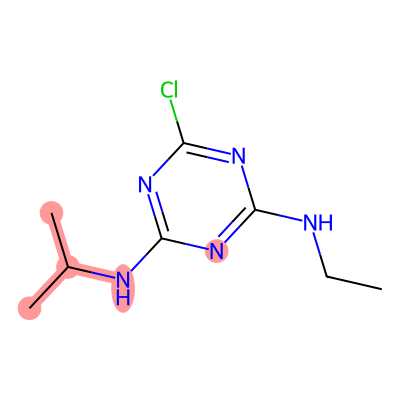

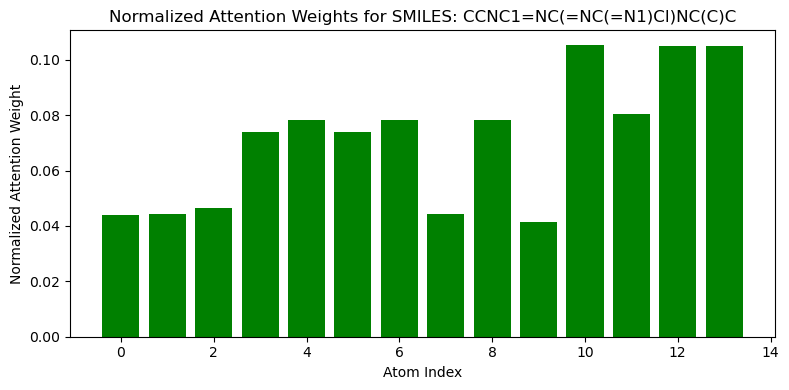


Task mgl - Visualise the attachment weights of Fold 19:
Top 1 SMILES: C1=CC=C2C(=C1)C3=CC=CC4=C3C5=C2C6=C(C=C5C=C4)[C@H]([C@@H]([C@H]7[C@@H]6O7)O)O, Prob: 0.5908
  Attention Scores: [0.05747136101126671, 0.05747136101126671, 0.05686409771442413, 0.02658361755311489, 0.02658361755311489, 0.05686409771442413, 0.02658361755311489, 0.05686409771442413, 0.05747136101126671, 0.05686409771442413, 0.052414823323488235, 0.02225816249847412, 0.02225816249847412, 0.02225816249847412, 0.022749701514840126, 0.02696337178349495, 0.03274638205766678, 0.05241481959819794, 0.05686409771442413, 0.05686409771442413, 0.022048650309443474, 0.021495074033737183, 0.02155306376516819, 0.02206757664680481, 0.02164444699883461, 0.021508364006876945, 0.022269774228334427]
SMILES: C1=CC=C2C(=C1)C3=CC=CC4=C3C5=C2C6=C(C=C5C=C4)[C@H]([C@@H]([C@H]7[C@@H]6O7)O)O
  Atom 0 (C): Attention Score = 0.0575
  Atom 1 (C): Attention Score = 0.0575
  Atom 2 (C): Attention Score = 0.0569
  Atom 3 (C): Attention Score = 0.0266
 

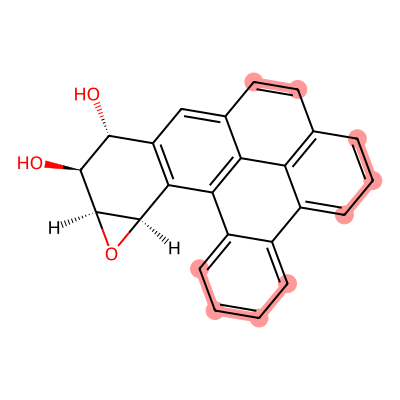

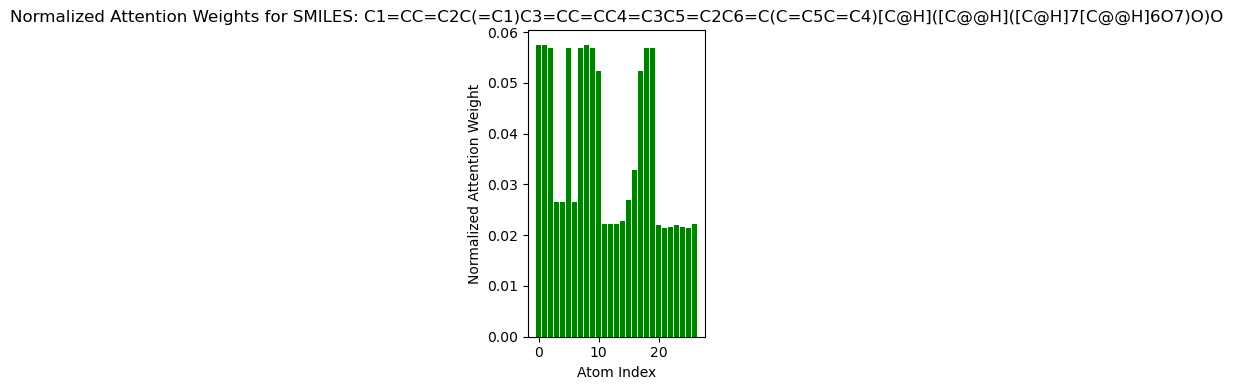

Top 2 SMILES: C1CC2=CC=C(C3=CC=CC1=C23)[N+](=O)[O-], Prob: 0.5832
  Attention Scores: [0.03979728743433952, 0.03979728743433952, 0.051078762859106064, 0.10349266231060028, 0.10349266231060028, 0.05739755928516388, 0.07595669478178024, 0.10349266231060028, 0.10381656885147095, 0.10349266231060028, 0.051078762859106064, 0.05150921270251274, 0.03886783495545387, 0.03846428170800209, 0.038265079259872437]
SMILES: C1CC2=CC=C(C3=CC=CC1=C23)[N+](=O)[O-]
  Atom 0 (C): Attention Score = 0.0398
  Atom 1 (C): Attention Score = 0.0398
  Atom 2 (C): Attention Score = 0.0511
  Atom 3 (C): Attention Score = 0.1035
  Atom 4 (C): Attention Score = 0.1035
  Atom 5 (C): Attention Score = 0.0574
  Atom 6 (C): Attention Score = 0.0760
  Atom 7 (C): Attention Score = 0.1035
  Atom 8 (C): Attention Score = 0.1038
  Atom 9 (C): Attention Score = 0.1035
  Atom 10 (C): Attention Score = 0.0511
  Atom 11 (C): Attention Score = 0.0515
  Atom 12 (N): Attention Score = 0.0389
  Atom 13 (O): Attention Score = 0.0385

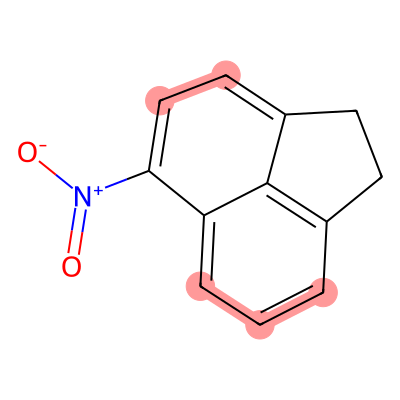

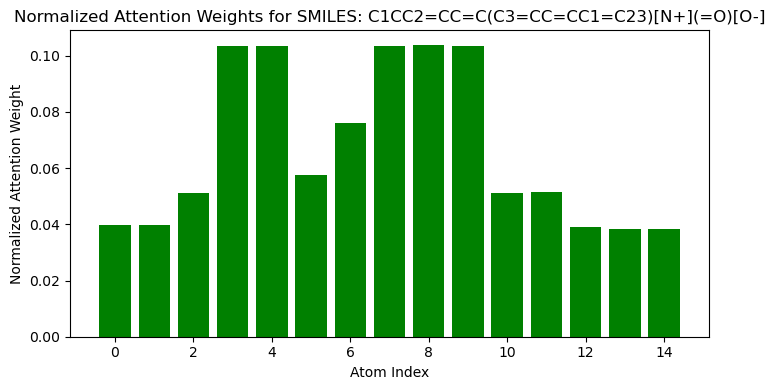

Top 3 SMILES: C1=C(OC(=C1)[N+](=O)[O-])C2=NN=C(O2)N, Prob: 0.5757
  Attention Scores: [0.12161625921726227, 0.11587470769882202, 0.0664968341588974, 0.105595663189888, 0.12161625921726227, 0.04609908536076546, 0.045326828956604004, 0.04486200585961342, 0.06355616450309753, 0.052458833903074265, 0.052458833903074265, 0.05181385576725006, 0.0664968341588974, 0.04572784900665283]
SMILES: C1=C(OC(=C1)[N+](=O)[O-])C2=NN=C(O2)N
  Atom 0 (C): Attention Score = 0.1216
  Atom 1 (C): Attention Score = 0.1159
  Atom 2 (O): Attention Score = 0.0665
  Atom 3 (C): Attention Score = 0.1056
  Atom 4 (C): Attention Score = 0.1216
  Atom 5 (N): Attention Score = 0.0461
  Atom 6 (O): Attention Score = 0.0453
  Atom 7 (O): Attention Score = 0.0449
  Atom 8 (C): Attention Score = 0.0636
  Atom 9 (N): Attention Score = 0.0525
  Atom 10 (N): Attention Score = 0.0525
  Atom 11 (C): Attention Score = 0.0518
  Atom 12 (O): Attention Score = 0.0665
  Atom 13 (N): Attention Score = 0.0457


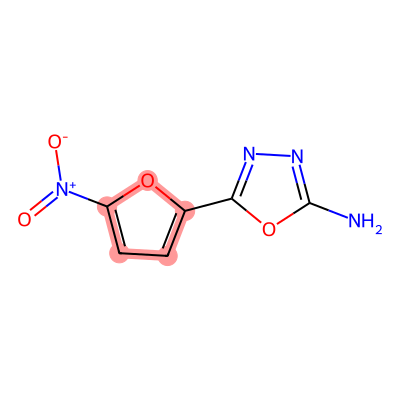

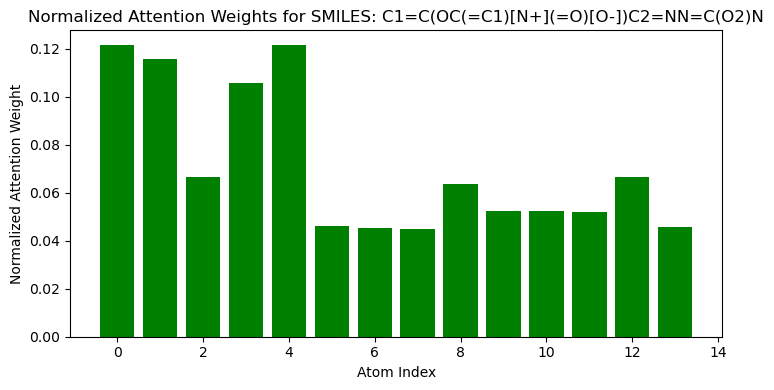

Top 4 SMILES: CCNC1=NC(=NC(=N1)Cl)NC(C)C, Prob: 0.5250
  Attention Scores: [0.044076379388570786, 0.044237054884433746, 0.046395763754844666, 0.07406890392303467, 0.07842713594436646, 0.07406889647245407, 0.07842713594436646, 0.04421917721629143, 0.07842713594436646, 0.04134904220700264, 0.10541525483131409, 0.08060331642627716, 0.10514244437217712, 0.10514244437217712]
SMILES: CCNC1=NC(=NC(=N1)Cl)NC(C)C
  Atom 0 (C): Attention Score = 0.0441
  Atom 1 (C): Attention Score = 0.0442
  Atom 2 (N): Attention Score = 0.0464
  Atom 3 (C): Attention Score = 0.0741
  Atom 4 (N): Attention Score = 0.0784
  Atom 5 (C): Attention Score = 0.0741
  Atom 6 (N): Attention Score = 0.0784
  Atom 7 (C): Attention Score = 0.0442
  Atom 8 (N): Attention Score = 0.0784
  Atom 9 (Cl): Attention Score = 0.0413
  Atom 10 (N): Attention Score = 0.1054
  Atom 11 (C): Attention Score = 0.0806
  Atom 12 (C): Attention Score = 0.1051
  Atom 13 (C): Attention Score = 0.1051


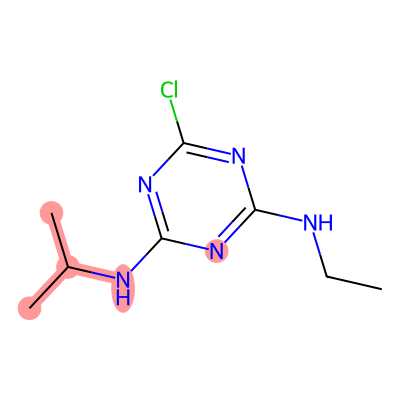

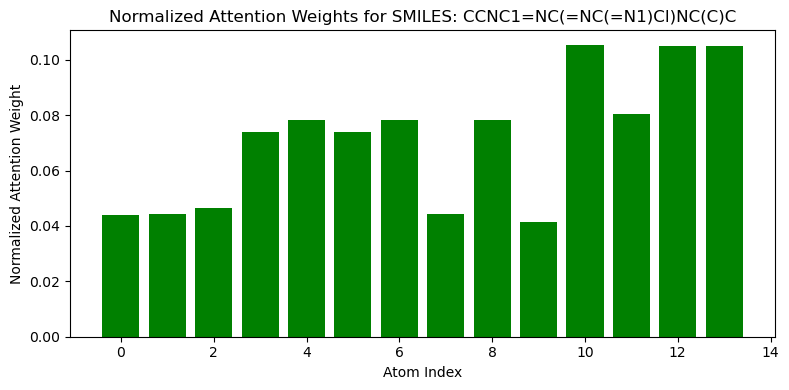

Top 5 SMILES: CCCCOC(=O)C1=CC=CC=C1C(=O)OCC2=CC=CC=C2, Prob: 0.5237
  Attention Scores: [0.025151792913675308, 0.025120440870523453, 0.02496323548257351, 0.025464093312621117, 0.025471579283475876, 0.025063183158636093, 0.024742545560002327, 0.03407354652881622, 0.06586509197950363, 0.0662960335612297, 0.0662960335612297, 0.06586509197950363, 0.03407355025410652, 0.025063183158636093, 0.024742545560002327, 0.025471579283475876, 0.027080297470092773, 0.05857786908745766, 0.06586509197950363, 0.0662960335612297, 0.0662960335612297, 0.0662960335612297, 0.06586509197950363]
SMILES: CCCCOC(=O)C1=CC=CC=C1C(=O)OCC2=CC=CC=C2
  Atom 0 (C): Attention Score = 0.0252
  Atom 1 (C): Attention Score = 0.0251
  Atom 2 (C): Attention Score = 0.0250
  Atom 3 (C): Attention Score = 0.0255
  Atom 4 (O): Attention Score = 0.0255
  Atom 5 (C): Attention Score = 0.0251
  Atom 6 (O): Attention Score = 0.0247
  Atom 7 (C): Attention Score = 0.0341
  Atom 8 (C): Attention Score = 0.0659
  Atom 9 (C): Attention 

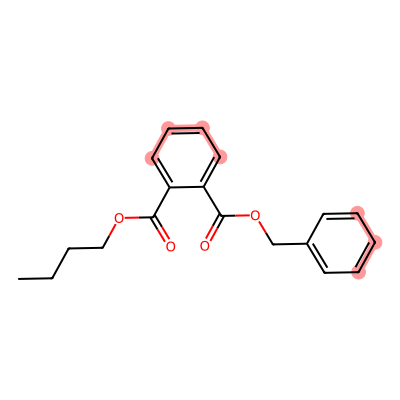

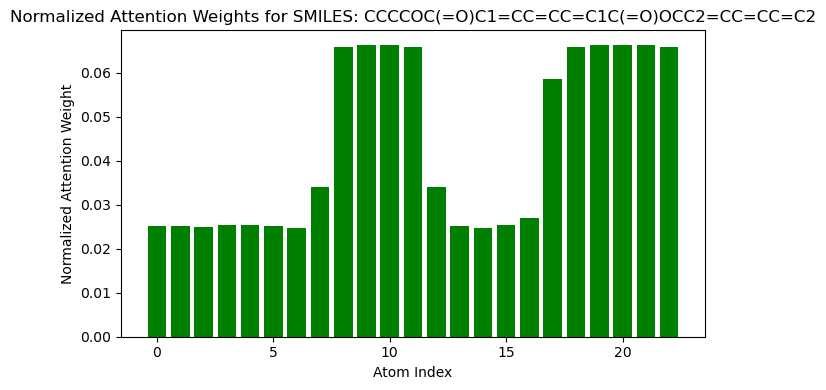

Top 6 SMILES: C1=CC2=C(C=C1Cl)OC3=C(O2)C=C(C=C3)Cl, Prob: 0.5227
  Attention Scores: [0.0928480327129364, 0.0928480327129364, 0.04711532965302467, 0.04711532965302467, 0.08583639562129974, 0.06442242860794067, 0.03431094065308571, 0.03550354391336441, 0.04711531847715378, 0.04711532220244408, 0.03550354391336441, 0.08583639562129974, 0.06442242860794067, 0.0928480327129364, 0.0928480327129364, 0.03431094065308571]
SMILES: C1=CC2=C(C=C1Cl)OC3=C(O2)C=C(C=C3)Cl
  Atom 0 (C): Attention Score = 0.0928
  Atom 1 (C): Attention Score = 0.0928
  Atom 2 (C): Attention Score = 0.0471
  Atom 3 (C): Attention Score = 0.0471
  Atom 4 (C): Attention Score = 0.0858
  Atom 5 (C): Attention Score = 0.0644
  Atom 6 (Cl): Attention Score = 0.0343
  Atom 7 (O): Attention Score = 0.0355
  Atom 8 (C): Attention Score = 0.0471
  Atom 9 (C): Attention Score = 0.0471
  Atom 10 (O): Attention Score = 0.0355
  Atom 11 (C): Attention Score = 0.0858
  Atom 12 (C): Attention Score = 0.0644
  Atom 13 (C): Attention S

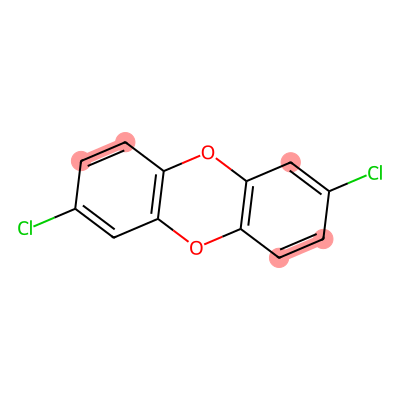

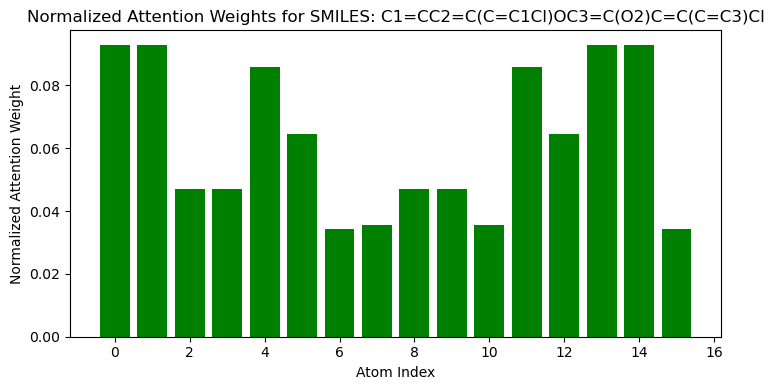


======================= Test and visualisation =======================


In [ ]:
class MultiTaskGAT(nn.Module):
    def __init__(self, num_features, n_heads1, output_dim_idx, dropout, num_tasks=4):
        super(MultiTaskGAT, self).__init__()

        self.conv2 = GATConv(num_features, num_features, heads=n_heads1, dropout=dropout)
        self.relu = nn.ReLU()
        self.graph_norm2 = GraphNorm(num_features * n_heads1)
        
        # Generate task combinations (combinations of 3 out of n_tasks)
        self.task_combinations_2 = list(combinations(range(num_tasks), 3))
        
        # Define hidden layers for each task combination
        self.hidden_layer2 = nn.ModuleList([
            nn.Sequential(
                nn.Linear(num_features * n_heads1, output_dim_idx),
                nn.ReLU(),
                nn.Dropout(dropout),
            ) for _ in self.task_combinations_2
        ])
        
        # Defining the final output layer
        self.final_layer = nn.ModuleList([nn.Linear(output_dim_idx, 1) for _ in range(num_tasks)])
        self.sigmoid = nn.Sigmoid()

        self.attention_net = nn.Sequential(
            nn.Linear(num_features * n_heads1, 16),
            nn.ReLU(),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )

        self.global_attention = GlobalAttention(gate_nn=self.attention_net)
        
        self.node_dropout = nn.Dropout(dropout)
        
        self.weight_matrix = nn.Parameter(torch.ones(len(self.task_combinations_2)))

    def forward(self, data, selected_tasks):
        x, edge_index, batch = data.x, data.edge_index, data.batch

        x2 = self.conv2(x, edge_index)
        x = self.graph_norm2(x2, batch)
        x = self.relu(x)
        x = self.node_dropout(x)

        # Attention Pooling
        x, attention_scores = self.global_attention(x, batch)

        # hidden_layer2: 3-task combination
        outputs = {task: [] for task in selected_tasks}
        for idx, (layer, combo) in enumerate(zip(self.hidden_layer2, self.task_combinations_2)):
            if set(combo).issubset(selected_tasks):
                output = layer(x)
                weight = self.weight_matrix[idx]
                for task in combo:
                    outputs[task].append(output * weight)
        
        # Combine the output 
        final_outputs = []
        for task in selected_tasks:
            if outputs[task]:
                combined_output = torch.sum(torch.stack(outputs[task]), dim=0) / len(outputs[task])
                final_output = self.final_layer[task](combined_output).view(-1)
                final_outputs.append(self.sigmoid(final_output))
            else:
                raise IndexError(f"Task {task} has no corresponding output in outputs dictionary.")

        return x, tuple(final_outputs), attention_scores

def visualize_attention_with_highlights(smiles, node_attention, top_percent=0.3):
    
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        print(f"Invalid SMILES string: {smiles}")
        return
    num_atoms = mol.GetNumAtoms()
    highlight_atom_indices = []

    if isinstance(node_attention, torch.Tensor):
        node_attention = node_attention.cpu().numpy().tolist()
    elif isinstance(node_attention, np.ndarray):
        node_attention = node_attention.tolist()
    elif isinstance(node_attention, list):
        pass  
    else:
        print(f"Unsupported node_attention type: {type(node_attention)}")
        return

    if len(node_attention) != num_atoms:
        print(f"Warning: Attention scores count ({len(node_attention)}) does not match number of atoms ({num_atoms}).")
        min_len = min(len(node_attention), num_atoms)
        node_attention = node_attention[:min_len]
        num_atoms = min_len

    top_n = max(1, int(np.ceil(top_percent * num_atoms)))
    sorted_indices = sorted(range(num_atoms), key=lambda i: node_attention[i], reverse=True)
    highlight_atom_indices = sorted(sorted_indices[:top_n])
    
    # Node attention score output
    print(f"SMILES: {smiles}")
    for idx, (atom, attn) in enumerate(zip(mol.GetAtoms(), node_attention)):
        print(f"  Atom {idx} ({atom.GetSymbol()}): Attention Score = {attn:.4f}")

    highlight_atom_indices = sorted(set(highlight_atom_indices))
    
    if len(highlight_atom_indices) > 0:
        highlight_colors = {idx: (1.0, 0.6, 0.6) for idx in highlight_atom_indices}
    else:
        highlight_colors = {}

    # Molecular visualisation
    drawer = Draw.MolDraw2DCairo(400, 400)
    opts = drawer.drawOptions()
    opts.highlightColour = (1.0, 0.0, 0.0)
    drawer.DrawMolecule(mol, highlightAtoms=highlight_atom_indices, highlightAtomColors=highlight_colors)
    drawer.FinishDrawing()
    img_data = drawer.GetDrawingText()
    
    img = Image.open(io.BytesIO(img_data))
    display(img)
    
    # Normalised Attention Weights bar graph visualisation
    plt.figure(figsize=(8, 4))
    plt.bar(range(len(node_attention)), node_attention, color='green')
    plt.title(f'Normalized Attention Weights for SMILES: {smiles}')
    plt.xlabel('Atom Index')
    plt.ylabel('Normalized Attention Weight')
    plt.tight_layout()
    plt.show()

# Define a function to output performance metrics
def printPerformance_multi(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    try:
        auc = roc_auc_score(y_true, y_pred)
    except ValueError:
        auc = np.nan
    try:
        pr_auc = average_precision_score(y_true, y_pred)
    except ValueError:
        pr_auc = np.nan
    y_pred_labels = (y_pred >= 0.45).astype(int)
    accuracy = accuracy_score(y_true, y_pred_labels)
    print(f"  AUC: {auc:.4f}, PR AUC: {pr_auc:.4f}, Accuracy: {accuracy:.4f}")


def extract_attention_scores_per_molecule(batch, node_attention, smiles):
    
    attention_scores_per_molecule = []
    selected_smiles = []
    
    num_molecules = batch.num_graphs
    
    for i in range(num_molecules):
        node_indices = (batch.batch == i).nonzero(as_tuple=True)[0]
        molecule_attention = node_attention[node_indices].cpu().numpy().flatten().tolist()
        molecule_smiles = smiles[i]
        selected_smiles.append(molecule_smiles)
        
        mol = Chem.MolFromSmiles(molecule_smiles)
        if mol is None:
            print(f"Invalid SMILES string: {molecule_smiles}")
            attention_scores_per_molecule.append([])
            continue
        
        num_atoms = mol.GetNumAtoms()
        atoms = [atom.GetSymbol() for atom in mol.GetAtoms()]
        
        if len(molecule_attention) != num_atoms:
            print(f"Warning: Attention scores count ({len(molecule_attention)}) does not match number of atoms ({num_atoms}).")
        
        attention_scores_per_molecule.append(molecule_attention)
    
    return attention_scores_per_molecule, selected_smiles

def save_predictions_to_csv(all_fold_results, list_tissue, output_dir='prediction_results'):
    
    os.makedirs(output_dir, exist_ok=True)
    
    task_data = {task: {'fold': [], 'smiles': [], 'y_true': [], 'y_pred': []} for task in list_tissue}
    
    for fold_result in all_fold_results:
        fold = fold_result['fold']
        smiles_list = fold_result['smiles']
        task_metrics = fold_result['task_metrics']
        
        for task_idx, task_name in enumerate(list_tissue):
            task_key = f"task_{task_idx}"
            y_true = task_metrics[task_key]['y_true']
            y_pred = task_metrics[task_key]['y_pred']
            
            for i, smiles in enumerate(smiles_list):
                task_data[task_name]['fold'].append(fold)
                task_data[task_name]['smiles'].append(smiles)
                task_data[task_name]['y_true'].append(y_true[i])
                task_data[task_name]['y_pred'].append(y_pred[i])
    
    for task_name, data in task_data.items():
        df = pd.DataFrame(data)
        csv_path = os.path.join(output_dir, f'{task_name}_predictions.csv')
        df.to_csv(csv_path, index=False)
        print(f"Saved predictions for task '{task_name}' to {csv_path}")

def test_and_collect(model, criterion, test_loader, device, list_tissue):
    model.eval()
    task_losses = defaultdict(float)
    num_batches = defaultdict(int)
    task_metrics = defaultdict(lambda: {'y_true': [], 'y_pred': []})
    
    all_node_attention_scores = []
    all_smiles = []
    
    with torch.no_grad():
        for batch in test_loader:
            batch = batch.to(device)
            
            x, list_task, node_attention_scores = model(batch, selected_tasks=tuple(range(len(list_tissue))))
            
            for task_idx, task in enumerate(list_tissue):
                task_key = f"task_{task_idx}"
                task_metrics[task_key]['y_true'].extend(batch.y[:, task_idx].cpu().tolist())
                task_metrics[task_key]['y_pred'].extend(list_task[task_idx].cpu().tolist())

            attention_scores_per_molecule, selected_smiles = extract_attention_scores_per_molecule(
                batch, node_attention_scores, smiles=batch.smiles)
            all_node_attention_scores.extend(attention_scores_per_molecule)
            all_smiles.extend(selected_smiles)

    task_results = {}
    
    for task_idx, task_name in enumerate(list_tissue):
        task_key = f"task_{task_idx}"
        if task_key in task_metrics:
            y_true = np.array(task_metrics[task_key]['y_true'])
            y_pred = np.array(task_metrics[task_key]['y_pred'])
            try:
                auc = roc_auc_score(y_true, y_pred)
            except ValueError:
                auc = np.nan

            try:
                pr_auc = average_precision_score(y_true, y_pred)
            except ValueError:
                pr_auc = np.nan

            y_pred_labels = (y_pred >= 0.45).astype(int)
            accuracy = accuracy_score(y_true, y_pred_labels)
            avg_loss = np.nan  
            task_results[task_key] = {
                'loss': avg_loss,
                'auc': auc,
                'pr_auc': pr_auc,
                'accuracy': accuracy
            }
        else:
            task_results[task_key] = {
                'loss': np.nan,
                'auc': np.nan,
                'pr_auc': np.nan,
                'accuracy': np.nan
            }
    return task_results, task_metrics, all_node_attention_scores, all_smiles

def main():
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    K = 20  
    all_fold_results = []
    list_tissue = ["liv", "lun", "sto", "mgl"]  
    task_mapping = {name: f"task_{idx}" for idx, name in enumerate(list_tissue)}
    
    all_task_results = {}
    
    data_dir = '/../../model/multi task/data'
    models_dir = '/../../model/multi task/model'

    model = MultiTaskGAT(num_features=75, n_heads1=2, output_dim_idx=16, dropout=0.2, num_tasks=len(list_tissue)).to(device)

    criterion = FocalLoss(alpha=0.25, gamma=4.0, reduction='mean')
    
    fold_attention_data = {}
    
    for fold in range(1, K + 1):
        print(f"\n======================= Fold {fold}/{K} test start =======================")

        # Loading a test dataset
        test_dataset_path = os.path.join(data_dir, f'fold_{fold}_test.pt')
        if not os.path.exists(test_dataset_path):
            print(f"Test data file {test_dataset_path} does not exist, skip fold {fold}.")
            continue

        test_dataset = torch.load(test_dataset_path)
        test_loader = TorchDataLoader(test_dataset, batch_size=8, shuffle=False, collate_fn=Batch.from_data_list, num_workers=0)

        # Load trained model weights
        model_path = os.path.join(models_dir, f'fold_{fold}_final.pth')
        if not os.path.exists(model_path):
            print(f"Model file {model_path} does not exist, skip Fold {fold}.")
            continue

        checkpoint = torch.load(model_path, map_location=device)
        model.load_state_dict(checkpoint)
        model.to(device)
        model.eval()
        
        task_results, task_metrics, all_node_attention_scores, all_smiles = test_and_collect(
            model, criterion, test_loader, device, list_tissue)
        
        fold_result = {
            'fold': fold,
            'test_results': task_results,
            'task_metrics': task_metrics,
            'node_attention_scores': all_node_attention_scores,
            'smiles': all_smiles
        }
        all_fold_results.append(fold_result)
        fold_attention_data[fold] = {
            'node_attention_scores': all_node_attention_scores,
            'smiles': all_smiles,
            'test_results': task_results,
            'task_metrics': task_metrics
        }

        # Output results by fold
        print(f"\nFold {fold} - Test Results:")
        for task_idx, task_name in enumerate(list_tissue):
            task_key = f"task_{task_idx}"
            if task_key in task_results:
                result = task_results[task_key]
                print(f"  Task {task_idx} ({task_name}): Loss={result['loss']:.4f}, AUC={result['auc']:.4f}, PR AUC={result['pr_auc']:.4f}, Accuracy={result['accuracy']:.4f}")

        for task_idx in range(len(list_tissue)):
            task_key = f"task_{task_idx}"
            if task_key not in all_task_results:
                all_task_results[task_key] = {'loss': [], 'auc': [], 'pr_auc': [], 'accuracy': []}
            if task_key in task_results:
                result = task_results[task_key]
                all_task_results[task_key]['loss'].append(result['loss'])
                all_task_results[task_key]['auc'].append(result['auc'])
                all_task_results[task_key]['pr_auc'].append(result['pr_auc'])
                all_task_results[task_key]['accuracy'].append(result['accuracy'])

    # Output results for all folds
    print("\n======================= Tested =======================")

    # Calculate and output the average result for all folds
    print("\n Average result for all folds:")
    
    avg_aucs = []
    std_aucs = []
    avg_pr_aucs = []
    std_pr_aucs = []
    tasks = list_tissue

    for task_idx, task_name in enumerate(list_tissue):
        task_key = f"task_{task_idx}"
        if task_key in all_task_results:
            losses = np.array(all_task_results[task_key]['loss'])
            aucs = np.array(all_task_results[task_key]['auc'])
            pr_aucs = np.array(all_task_results[task_key]['pr_auc'])
            accuracies = np.array(all_task_results[task_key]['accuracy'])

            avg_loss = np.nanmean(losses)
            avg_auc = np.nanmean(aucs)
            avg_pr_auc = np.nanmean(pr_aucs)
            avg_accuracy = np.nanmean(accuracies)

            std_auc = np.nanstd(aucs)
            std_pr_auc = np.nanstd(pr_aucs)

            avg_aucs.append(avg_auc)
            std_aucs.append(std_auc)
            avg_pr_aucs.append(avg_pr_auc)
            std_pr_aucs.append(std_pr_auc)

            print(f"Task {task_idx} ({task_name}):")
            print(f"  Average Test Loss: {avg_loss:.4f}")
            print(f"  Average Test AUC: {avg_auc:.4f} ± {std_auc:.4f}")
            print(f"  Average Test PR AUC: {avg_pr_auc:.4f} ± {std_pr_auc:.4f}")
            print(f"  Average Test Accuracy: {avg_accuracy:.4f}")
        else:
            avg_aucs.append(np.nan)
            std_aucs.append(np.nan)
            avg_pr_aucs.append(np.nan)
            std_pr_aucs.append(np.nan)
            print(f"Task {task_idx} ({task_name}): No data ")
    
    x = np.arange(len(tasks))  
    width = 0.35 
    fig, ax = plt.subplots(figsize=(12, 7))
    rects1 = ax.bar(x - width/2, avg_aucs, width, yerr=std_aucs, label='AUC', capsize=5, color='skyblue')
    rects2 = ax.bar(x + width/2, avg_pr_aucs, width, yerr=std_pr_aucs, label='PR AUC', capsize=5, color='salmon')

    ax.set_ylabel('Scores')
    ax.set_title('Average AUC and PR AUC by Task with Standard Deviation')
    ax.set_xticks(x)
    ax.set_xticklabels(tasks)
    ax.legend()

    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            if not np.isnan(height):
                ax.annotate(f'{height:.2f}',
                            xy=(rect.get_x() + rect.get_width() / 2, height),
                            xytext=(0, 3),  
                            textcoords="offset points",
                            ha='center', va='bottom')

    autolabel(rects1)
    autolabel(rects2)

    fig.tight_layout()
    plt.show()

    save_predictions_to_csv(all_fold_results, list_tissue)

    best_fold = None
    best_pr_auc = -1.0
    for fold_result in all_fold_results:
        fold = fold_result['fold']
        test_results = fold_result['test_results']
        # Compute average PR AUC across tasks
        pr_aucs = [test_results[f"task_{i}"]['pr_auc'] for i in range(len(list_tissue)) if f"task_{i}" in test_results]
        avg_pr_auc = np.nanmean(pr_aucs)
        if avg_pr_auc > best_pr_auc:
            best_pr_auc = avg_pr_auc
            best_fold = fold

    if best_fold is not None:
        print(f"\nFolds with the highest average PR AUC: Fold {best_fold} with PR AUC={best_pr_auc:.4f}")
    # -------------------------
    worst_fold = None
    worst_pr_auc = float('inf')
    for fold_result in all_fold_results:
        fold = fold_result['fold']
        test_results = fold_result['test_results']
        pr_aucs = [test_results[f"task_{i}"]['pr_auc'] for i in range(len(list_tissue)) if f"task_{i}" in test_results]
        avg_pr_auc = np.nanmean(pr_aucs)
        if avg_pr_auc < worst_pr_auc:
            worst_pr_auc = avg_pr_auc
            worst_fold = fold

    if worst_fold is not None:
        print(f"\nFolds with the lowest average PR AUC: Fold {worst_fold} with PR AUC={worst_pr_auc:.4f}")

        best_fold_data = fold_attention_data[best_fold]
        best_node_attention_scores = best_fold_data['node_attention_scores']
        best_smiles = best_fold_data['smiles']
        best_task_results = best_fold_data['test_results']
        best_task_metrics = best_fold_data['task_metrics']

        task_details = {f"task_{i}": [] for i in range(len(list_tissue))}
        for i, (attention_scores, smiles) in enumerate(zip(best_node_attention_scores, best_smiles)):
            for task_idx in range(len(list_tissue)):
                task_key = f"task_{task_idx}"
                if best_task_metrics[task_key]['y_true'][i] == 1 and best_task_metrics[task_key]['y_pred'][i] >= 0.45:
                    task_details[task_key].append((smiles, attention_scores))

        print(f"\nNumber of 0s and 1s for each task in Fold {best_fold}:")
        for task_idx, task_name in enumerate(list_tissue):
            task_key = f"task_{task_idx}"
            if task_key in best_task_metrics:
                y_true = np.array(best_task_metrics[task_key]['y_true']).astype(int)  
                counts = np.bincount(y_true, minlength=2)
                num_zeros = counts[0]
                num_ones = counts[1] if len(counts) > 1 else 0
                print(f"  Task {task_idx} ({task_name}): Number of zeros= {num_zeros}, Number of 1s = {num_ones}")
            else:
                print(f"  Task {task_idx} ({task_name}): No data")
        
        for task_idx, task_name in enumerate(list_tissue):
            task_key = f"task_{task_idx}"
            print("======================================================================================================")
            print("======================================================================================================")
            print(f"\nTask {task_name} - Visualise the attachment weights of Fold {best_fold}:")
            
            if task_key in best_task_metrics:
                y_pred = np.array(best_task_metrics[task_key]['y_pred'])
                pr_auc = best_task_results[task_key]['pr_auc']
                
                top_n = 10
                positive_indices = [
                    i for i, (y_true, y_val) in enumerate(
                        zip(best_task_metrics[task_key]['y_true'], best_task_metrics[task_key]['y_pred'])
                    ) if y_true == 1 and y_val >= 0.45
                ]
                positive_y_pred = y_pred[positive_indices]
                
                if len(positive_y_pred) == 0:
                    print(f"No positive samples for task {task_name} with both y_true=1 and y_pred>=0.45.")
                    continue
                
                positive_data = task_details[task_key]
                if len(positive_data) != len(positive_y_pred):
                    print("Mismatch in length of positive data and predictions")
                    continue

                positive_predictions_and_data = list(zip(positive_y_pred, positive_data))
                sorted_positive_predictions_and_data = sorted(positive_predictions_and_data, key=lambda x: x[0], reverse=True)
                top_n_data = sorted_positive_predictions_and_data[:top_n]

                for i, (prob, (smiles, attention_scores)) in enumerate(top_n_data, start=1):
                    print(f"Top {i} SMILES: {smiles}, Prob: {prob:.4f}")
                    print(f"  Attention Scores: {attention_scores}")
                    
                    visualize_attention_with_highlights(smiles, attention_scores, top_percent=0.3)

                
            else:
                print(f"No data available for task {task_name}")
    else:
        print("fold x")

    print("\n======================= Test and visualisation =======================")

if __name__ == "__main__":
    main()
